# Technical Assignment: Time Series Forecasting – Sam Stockman, Senior Data Scientist 

This notebook presents an exploratory analysis and forecasting solution for Wikipedia page view data.


## 1. Dataset Processing & Cleaning

In this section, we prepare the Wikipedia page view dataset for modelling.

### Overview:

- **Read the train and test datasets**
- **Initial NaN Inspection**
  - Count and classify types of missingness: 
    - Pages with a late start
    - Pages with an early end
    - Pages with internal gaps
- **Missing Data Visualisation**
  - Bar plots showing missing data types across train and test sets
- **Test/Train Consistency Check**
  - Verify that pages ending early in training set are *not* present in test set
- **Internal Gaps Handling**
  - Pages with internal gaps **longer than 2 days** are removed
  - Remaining gaps are **linearly interpolated**
- **Final Data Integrity Checks**
  - Ensure that after cleaning, the **only remaining NaNs** are due to late-starting pages
- **Range Check on Page Views**
  - Verify the scale and distribution of values
  - Detect and correct a single erroneous **negative page view** value



### Library Imports and Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import re
import os

# For time series analysis
from statsmodels.tsa.stattools import acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import VAR

from sklearn.linear_model import LinearRegression

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
raw_train_df = pd.read_csv('data/train.csv')
raw_test_df = pd.read_csv('data/test.csv')

raw_train_df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2017-08-02  2017-08-03  2017-08-04  2017-08-05  \
0        26.0  ...        46.0        24.0        22.0        22.0   
1        10.0  ...        39.0        20.0        31.0        19.0   
2         4.0  ...        22.0         8.0         4.0         3.0   
3        11.0  ...        37.0        14.0        12.0        13.0   
4         NaN  ...        40.0        39.0        66.0       114.0   

   2017-08-06  2017-08-07  2017-08-08  2017-08-09  2017-08-10  2017-08-11  
0        11.0        25.0        45.0        39.0        17.0        18.0  
1         7.0        11.0        20.0        13.0        16.0        16.0  
2         1.0         3.0         7.0         3.0         1.0         9.0  
3        11.0        10.0        14.0        15.0        15.0        11.0  
4        19.0        29.0        12.0        11.0        14.0        14.0  

[5 rows x 777 columns]

# Data Cleaning

### Formating

In [3]:
raw_train_df = raw_train_df.set_index('Page')
raw_train_df.columns = pd.to_datetime(raw_train_df.columns,format='mixed')

raw_test_df = raw_test_df.set_index('Page')
raw_test_df.columns = pd.to_datetime(raw_test_df.columns,format='mixed')


### Check for missing data

In [4]:
print(f'train_df has {raw_train_df.isna().sum().sum()} missing values')
print(f'test_df has {raw_test_df.isna().sum().sum()} missing values')

train_df has 3575063 missing values
test_df has 40403 missing values


There are three main types of missingness that can occur in this kind of time series dataset:

1. **Late Start** — The page comes online after data collection begins.
2. **Internal Gaps** — The page has missing values within its time series.
3. **Early End** — The page goes offline before the end of the dataset timeframe.

Let's visualise the number of pages affected by each type of missingness.

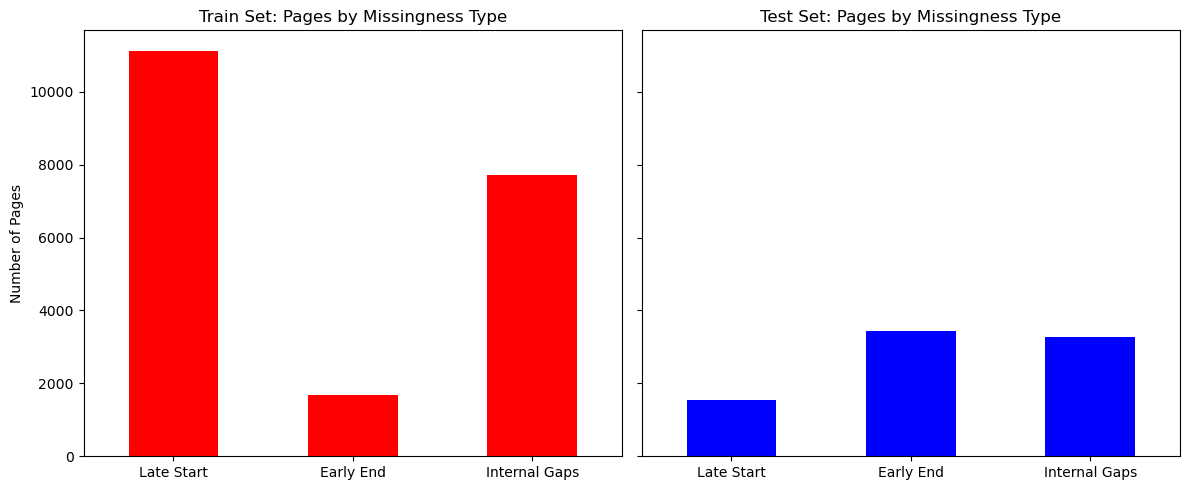

In [5]:
def get_missingness_masks(df):
    """
    Return boolean Series indicating missingness types for each row in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame with datetime columns, pages as rows.

    Returns:
        dict of pd.Series: {'Late Start': ..., 'Early End': ..., 'Internal Gaps': ...}
    """
    late_start = df.apply(lambda row: row.first_valid_index() != df.columns[0], axis=1)
    early_end = df.apply(lambda row: row.last_valid_index() != df.columns[-1], axis=1)
    internal_gaps = df.apply(lambda row: row.loc[row.first_valid_index():row.last_valid_index()].isna().any(), axis=1)

    return {
        'Late Start': late_start,
        'Early End': early_end,
        'Internal Gaps': internal_gaps
    }

# Get masks
train_masks = get_missingness_masks(raw_train_df)
test_masks = get_missingness_masks(raw_test_df)

# Summarise
missing_train = pd.Series({key: mask.sum() for key, mask in train_masks.items()})
missing_test = pd.Series({key: mask.sum() for key, mask in test_masks.items()})

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

missing_train.plot(kind='bar', color='red', ax=axes[0])
axes[0].set_title('Train Set: Pages by Missingness Type')
axes[0].set_ylabel('Number of Pages')
axes[0].tick_params(axis='x', rotation=0)

missing_test.plot(kind='bar', color='blue', ax=axes[1])
axes[1].set_title('Test Set: Pages by Missingness Type')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()



For the purposes of this task, **late-starting pages are not a concern**, as we can still fit time series models to the available history and generate future forecasts. Our primary focus will be on handling internal gaps and early-ending pages, which may disrupt modelling and evaluation.

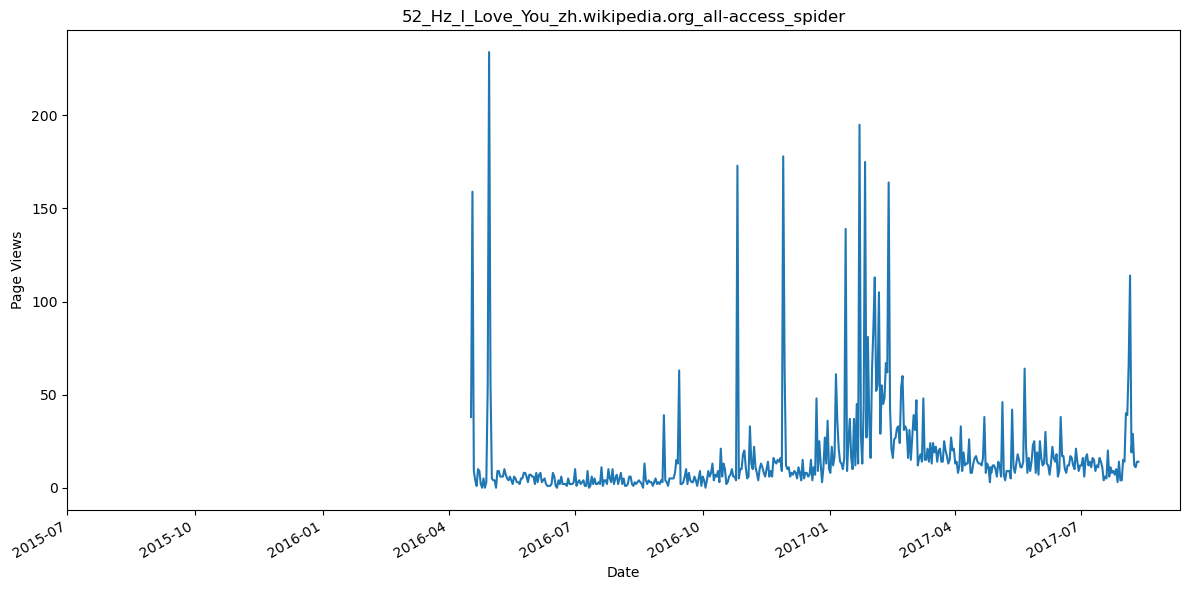

In [6]:
# Get the index of a page with late start (first True)
late_start_train_page = raw_train_df.loc[train_masks['Late Start'].idxmax()]
# Plot
late_start_train_page.plot(title='Late Start Page', figsize=(12, 6))
plt.xlim(pd.to_datetime('2015-07-01'), pd.to_datetime('2017-09-10'))
plt.title(late_start_train_page.name)
plt.ylabel('Page Views')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

Let's visualise the **'Internal Gaps'** pages.

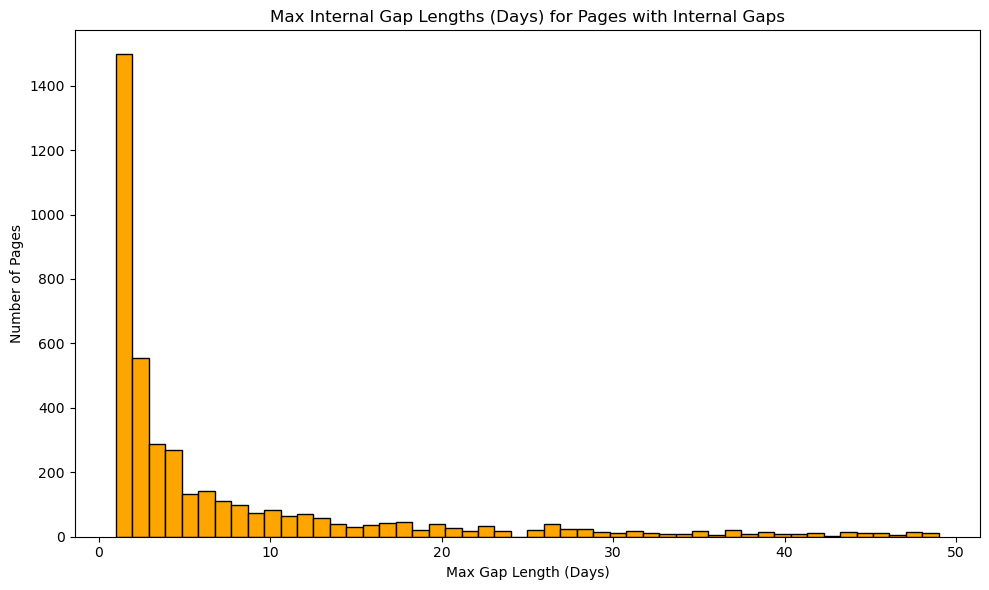

In [7]:
def max_gap_length(row):
    """Returns the maximum number of consecutive NaNs in a row (time series)."""
    is_nan = row.isna().values
    if not is_nan.any():
        return 0
    gap_lengths = []
    current_gap = 0
    for val in is_nan:
        if val:
            current_gap += 1
        elif current_gap > 0:
            gap_lengths.append(current_gap)
            current_gap = 0
    if current_gap > 0:
        gap_lengths.append(current_gap)
    return max(gap_lengths) if gap_lengths else 0

# === Get internal gap mask ===
internal_gaps_train = train_masks["Internal Gaps"]

# === Filter pages with internal gaps only ===
internal_gap_df = raw_train_df[internal_gaps_train]

# === Compute max gap length per page ===
max_gap_lengths = internal_gap_df.apply(max_gap_length, axis=1)

# === Truncate for visualization (e.g. cap at 50 days) ===
max_gap_lengths = max_gap_lengths[max_gap_lengths < 50]

# === Plot ===
plt.figure(figsize=(10, 6))
plt.hist(max_gap_lengths, bins=50, color='orange', edgecolor='black')
plt.title('Max Internal Gap Lengths (Days) for Pages with Internal Gaps')
plt.xlabel('Max Gap Length (Days)')
plt.ylabel('Number of Pages')
plt.tight_layout()
plt.show()


Fortunately, most pages in the dataset contain only small internal gaps, which allows us to use simple linear interpolation without significantly distorting the underlying signal. While more sophisticated imputation methods could be explored for larger gaps, for the purposes of this exercise we will take a pragmatic approach: we will **remove pages with gaps longer than 2 days** and **linearly interpolate the rest**.


In [8]:
# Separate pages without and with internal gaps
no_gap_pages = raw_train_df[~internal_gaps_train]
internal_gap_df = raw_train_df[internal_gaps_train]

# Filter pages with max gap length ≤ 2 and interpolate missing values
max_gap_lengths = internal_gap_df.apply(max_gap_length, axis=1)
gap_ok_pages = internal_gap_df.loc[max_gap_lengths[max_gap_lengths <= 2].index]
gap_ok_pages_filled = gap_ok_pages.interpolate(method='linear', axis=1, limit_direction='both')

# Combine filtered pages and align test set
raw_train_df_filtered = pd.concat([no_gap_pages, gap_ok_pages_filled])
raw_test_df_filtered = raw_test_df.loc[raw_train_df_filtered.index]


# Report results
print(f'Removed {len(raw_train_df) - len(raw_train_df_filtered)} pages with internal gaps > 2 days')
print(f"Remaining pages: {len(raw_train_df_filtered)} (Train), {len(raw_test_df_filtered)} (Test)")


Removed 5657 pages with internal gaps > 2 days
Remaining pages: 64343 (Train), 64343 (Test)


Let's again visualise the types of missingness we have:

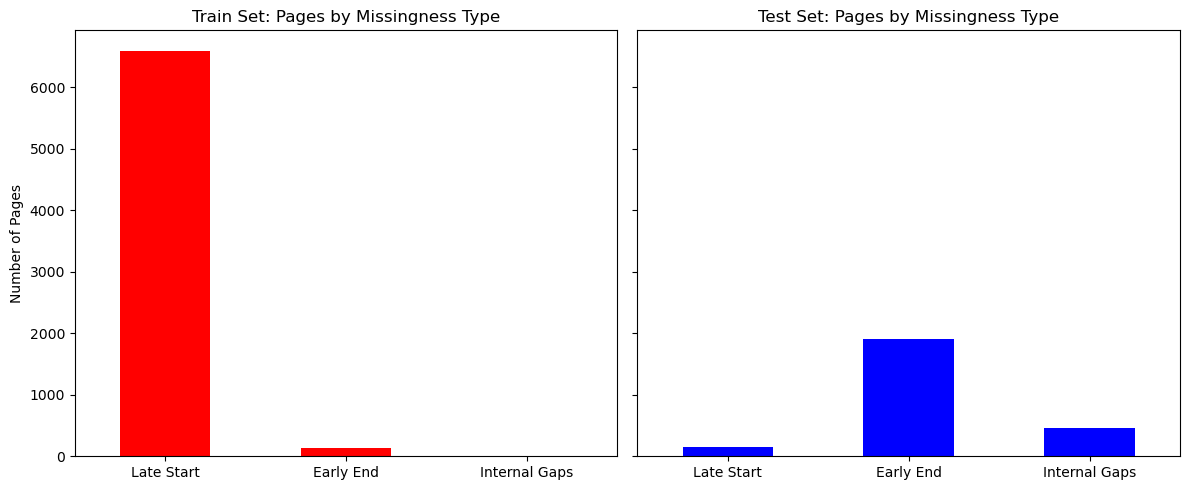

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# === Train set (filtered) ===
missing_train_masks = get_missingness_masks(raw_train_df_filtered)
missing_train = pd.Series({key: mask.sum() for key, mask in missing_train_masks.items()})
missing_train.plot(kind='bar', color='red', ax=axes[0])
axes[0].set_title('Train Set: Pages by Missingness Type')
axes[0].set_ylabel('Number of Pages')
axes[0].tick_params(axis='x', rotation=0)

# === Test set (filtered) ===
missing_test_masks = get_missingness_masks(raw_test_df_filtered)
missing_test = pd.Series({key: mask.sum() for key, mask in missing_test_masks.items()})
missing_test.plot(kind='bar', color='blue', ax=axes[1])
axes[1].set_title('Test Set: Pages by Missingness Type')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


Since we will not be **fitting** any models to the test set, we are less concerned about its missing values and will leave them as they are. These gaps can be addressed or flagged during the evaluation phase. 

Additionally, most of the pages with an **early end** also exhibited **internal gaps**, and were already removed during the earlier cleaning step. As a final clean-up, we will remove any remaining pages in the training set that end early, since they lack sufficient future context and cannot be used for forecasting.


In [10]:
# drop the remaining pages with an early end
train_df = raw_train_df_filtered[~missing_train_masks['Early End']]
test_df = raw_test_df_filtered[~missing_train_masks['Early End']]

### Check the values of the page counts

In [11]:
train_values = train_df.values.flatten()
print('Max (Train): ', np.nanmax(train_values), 'Min (Train): ', np.nanmin(train_values))

test_values = test_df.values.flatten()
print('Max (Test): ', np.nanmax(test_values), 'Min (Test): ', np.nanmin(test_values))

Max (Train):  123456789000.0 Min (Train):  -601.0
Max (Test):  19062496.0 Min (Test):  0.0


In [12]:
print('Number of negative values: ',sum(train_values < 0))

Number of negative values:  1


It appears that one of the pages in the training set contains a negative value, which is not valid for page view counts. Let's quickly visualise this anomaly before correcting it.

Page: Frecuencia_es.wikipedia.org_desktop_all-agents
Day: 2015-07-05 00:00:00


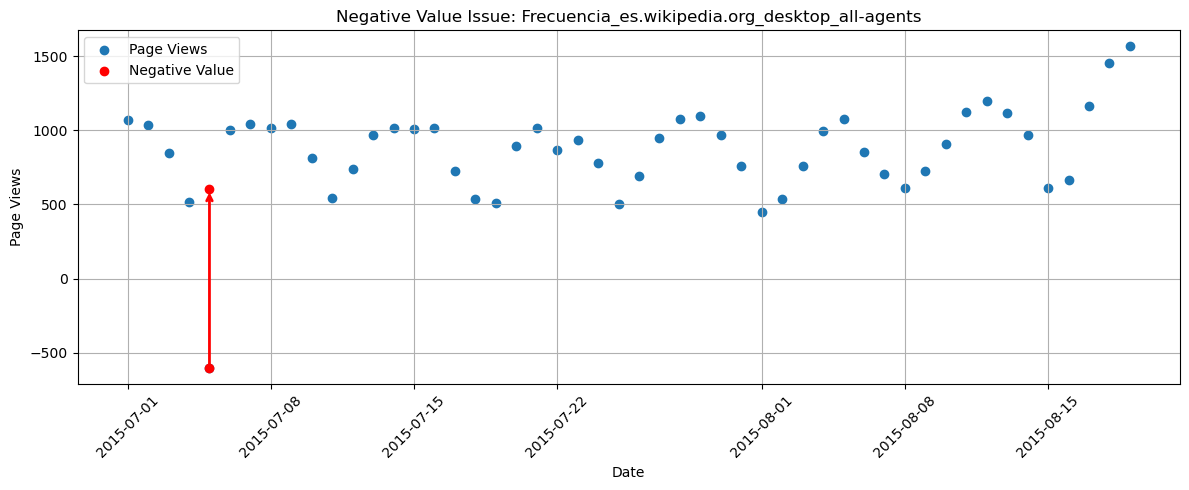

In [13]:
# Identify page and date with a negative value
page_with_negative_value = train_df[(train_df < 0).any(axis=1)].index[0]
day_of_negative_value = train_df.loc[page_with_negative_value][train_df.loc[page_with_negative_value] < 0].index[0]

print('Page:', page_with_negative_value)
print('Day:', day_of_negative_value)

# Extract the data for the specific page
page_data = train_df.loc[page_with_negative_value]

plt.figure(figsize=(12, 5))

# Plot first 50 data points
plt.scatter(page_data.index[:50], page_data.values[:50], marker='o', label='Page Views')

# Plot the red marker for the negative value
pos_y = page_data.loc[day_of_negative_value]
neg_y = -pos_y

plt.scatter([day_of_negative_value], [pos_y], color='red', zorder=5, label='Negative Value')
plt.scatter([day_of_negative_value], [neg_y], color='red', zorder=5)

# Vertical arrow between them
plt.annotate(
    '',
    xy=(day_of_negative_value, neg_y),
    xytext=(day_of_negative_value, pos_y),
    arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=2)
)

plt.title(f"Negative Value Issue: {page_with_negative_value}")
plt.xlabel("Date")
plt.ylabel("Page Views")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()


We can fairly assume this datapoint counts an eronious negative sign and can simply be corrected.

In [14]:
# change this value in the df
train_df.loc[page_with_negative_value, day_of_negative_value] = neg_y
# check if the value is now negative
assert train_df.loc[page_with_negative_value, day_of_negative_value] >=0

## Exploratory Data Analysis

In this section, we conduct an initial exploratory analysis to better understand the structure and characteristics of the data. These insights will directly inform our modelling choices in later sections.

### Overview

- We begin by visualising the overall distribution of page view counts across time, focusing on representative quantiles of the time series data.
- We then quantify key temporal properties — such as trend, seasonality, and autocorrelation — using autocorrelation function (ACF) plots.


Let's first visualise the quantiles of the whole time series of ~65,000 pages.

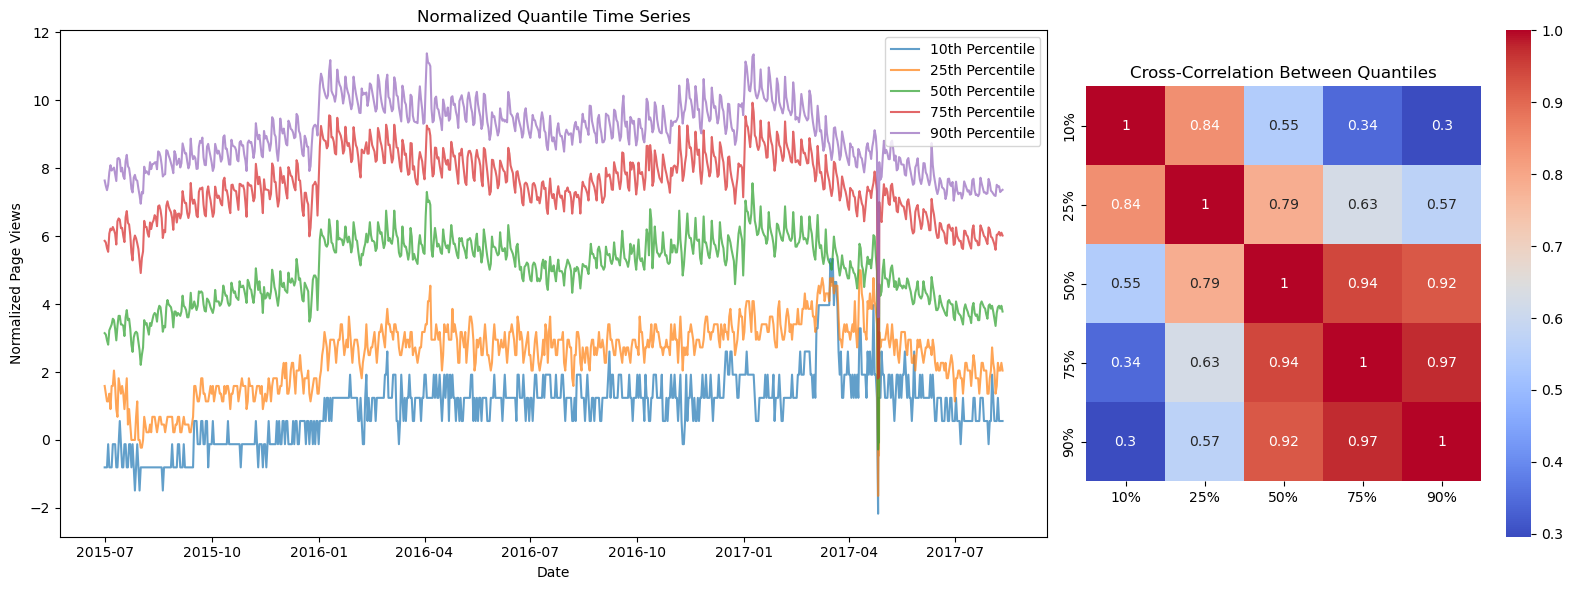

In [15]:
# Calculate and normalize quantile time series
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_ts = {q: train_df.quantile(q, axis=0, numeric_only=True) for q in quantiles}
quantile_norm = {q: (series - series.mean()) / series.std() for q, series in quantile_ts.items()}
quantile_df = pd.DataFrame(quantile_norm)

# Compute correlation matrix
corr_matrix = quantile_df.corr()

# Plot quantile time series and correlation heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

# Time series plot
for q in quantiles:
    ax1.plot(quantile_df[q] + q * 10, label=f'{int(q * 100)}th Percentile', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Page Views')
ax1.set_title('Normalized Quantile Time Series')
ax1.legend()

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=[f'{int(q*100)}%' for q in quantiles],
            yticklabels=[f'{int(q*100)}%' for q in quantiles], ax=ax2, square=True)
ax2.set_title('Cross-Correlation Between Quantiles')

plt.tight_layout()
plt.show()


From the visualisation, we can draw two key insights:

1. **Pronounced Short-term Seasonality in Higher Quantiles**  
   The upper quantiles (75th and 90th percentiles) display clear and regular oscillations, indicative of strong short-term seasonality. This suggests that popular pages tend to follow consistent viewing patterns—likely shaped by recurring events, habitual user engagement, or content relevance possibly tied to the day of the week.

2. **High Correlation Among High-Traffic Pages**  
   The correlation heatmap reveals that the 50th, 75th, and 90th percentile time series are strongly correlated (ρ > 0.9), indicating they share similar temporal behaviour. In contrast, the lower quantiles (10th and 25th percentiles) show weaker correlation with the rest—suggesting they represent a distinct regime of sparse, noisy, or erratic page activity with less apparent structure.

These observations suggest that different forecasting strategies might be beneficial across quantiles—particularly modelling seasonality more explicitly for high-traffic pages.

To further explore these behavioural differences, we next examine **Autocorrelation Function (ACF)** plots, which quantify how correlated a time series is with its past values at different lags.


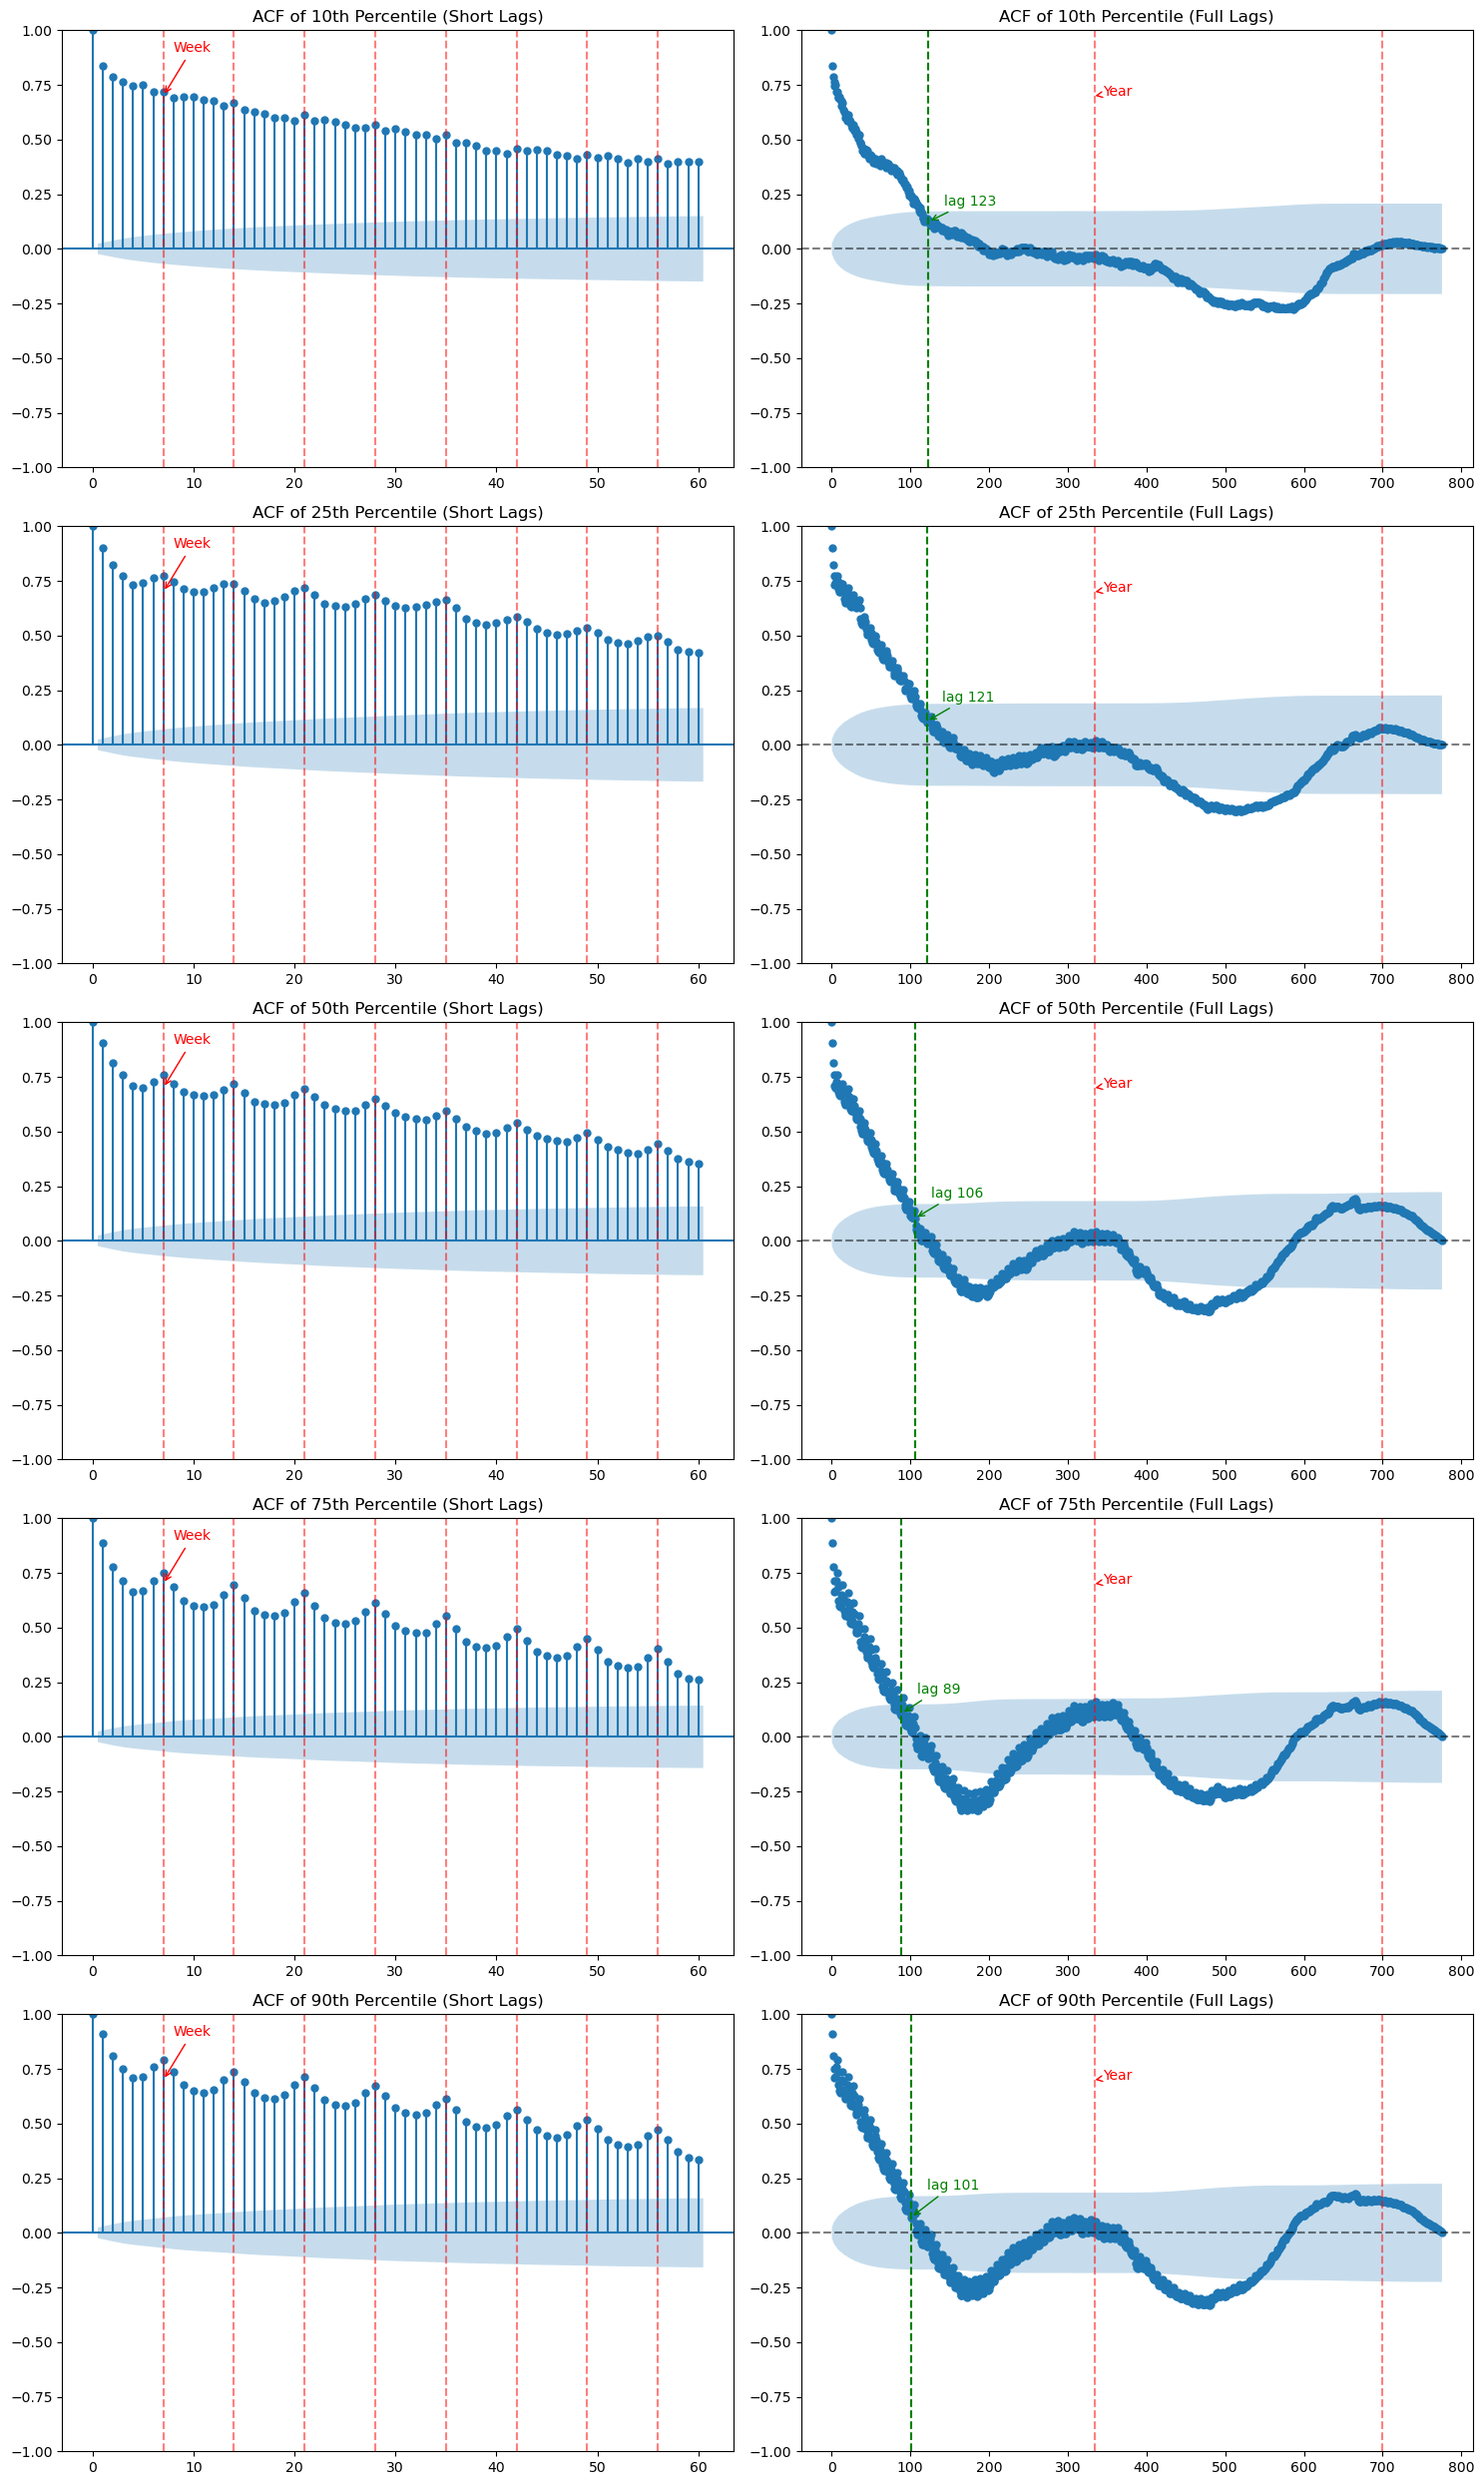

In [16]:
fig, axes = plt.subplots(len(quantile_ts), 2, figsize=(15, 5 * len(quantile_ts)))

for i, (quantile, ts) in enumerate(quantile_ts.items()):
    ts = ts.dropna()

    # === LEFT: Short lags (up to 60) ===
    plot_acf(ts, lags=60, ax=axes[i, 0], use_vlines=True, alpha=0.5)
    axes[i, 0].set_title(f'ACF of {int(quantile * 100)}th Percentile (Short Lags)')

    for j in range(1, 9):
        lag = j * 7
        axes[i, 0].axvline(x=lag, color='red', linestyle='--', alpha=0.5)
        if j == 1:
            axes[i, 0].annotate("Week", xy=(lag, 0.7), xytext=(lag + 1, 0.9),
                                textcoords="data", arrowprops=dict(arrowstyle="->", color='red'), color='red')

    # === RIGHT: Full lags ===
    max_lag = len(ts) - 1
    acf_vals = acf(ts, nlags=max_lag)

    plot_acf(ts, lags=max_lag, ax=axes[i, 1], use_vlines=False, alpha=0.5)
    axes[i, 1].set_title(f'ACF of {int(quantile * 100)}th Percentile (Full Lags)')
    axes[i, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    for j in range(1, 3):
        lag = j * 365 - 30
        axes[i, 1].axvline(x=lag, color='red', linestyle='--', alpha=0.5)
        if j == 1:
            axes[i, 1].annotate("Year", xy=(lag, 0.7), xytext=(lag + 10, 0.7),
                                textcoords="data", arrowprops=dict(arrowstyle="->", color='red'), color='red')

    # === Find the lag where ACF drops into confidence interval ===
    conf_level = 2 * (1.96 / np.sqrt(len(ts)))  # 95% CI
    below_threshold_lags = [lag for lag, val in enumerate(acf_vals[1:], start=1) if abs(val) < conf_level]
    if len(below_threshold_lags) >= 7:
        lag_7th_below = below_threshold_lags[6]
        val_7th_below = acf_vals[lag_7th_below]

        axes[i, 1].axvline(x=lag_7th_below, color='green', linestyle='--')
        axes[i, 1].annotate(f'lag {lag_7th_below}',
                            xy=(lag_7th_below, val_7th_below),
                            xytext=(lag_7th_below + 20, 0.2),
                            arrowprops=dict(arrowstyle='->', color='green'),
                            color='green')

plt.tight_layout()
plt.show()


These autocorrelation plots reveal several key temporal characteristics of the data:

- **Weekly Seasonality**: All quantiles display a repeating 7-day autocorrelation pattern, indicating weekly seasonality. This effect is strongest in the upper quantiles, suggesting that high-traffic pages tend to follow a regular weekly rhythm. For the lowest quantile, the weekly signal is present but much weaker.

- **Annual Seasonality**: A subtle peak near a 1-year lag (~365 days) appears in most quantiles, indicating the presence of yearly cycles—though this is significantly less pronounced than the weekly signal.

- **Long-Term Trend Structure**: All quantiles exhibit slowly decaying autocorrelations that remain above the confidence bounds up to around 90–120 days. This suggests the presence of persistent trend components or low-frequency drift in page view behaviour.

Together, these patterns motivate the use of time series models that capture both trend and seasonality. While a more nuanced approach might involve modelling high- and low-traffic pages differently, the presence of weekly seasonality across all quantiles justifies a unified treatment for the purposes of this exercise.

The differences might arise from lower pages counts being more popular on different days of the week to the higher count pages:

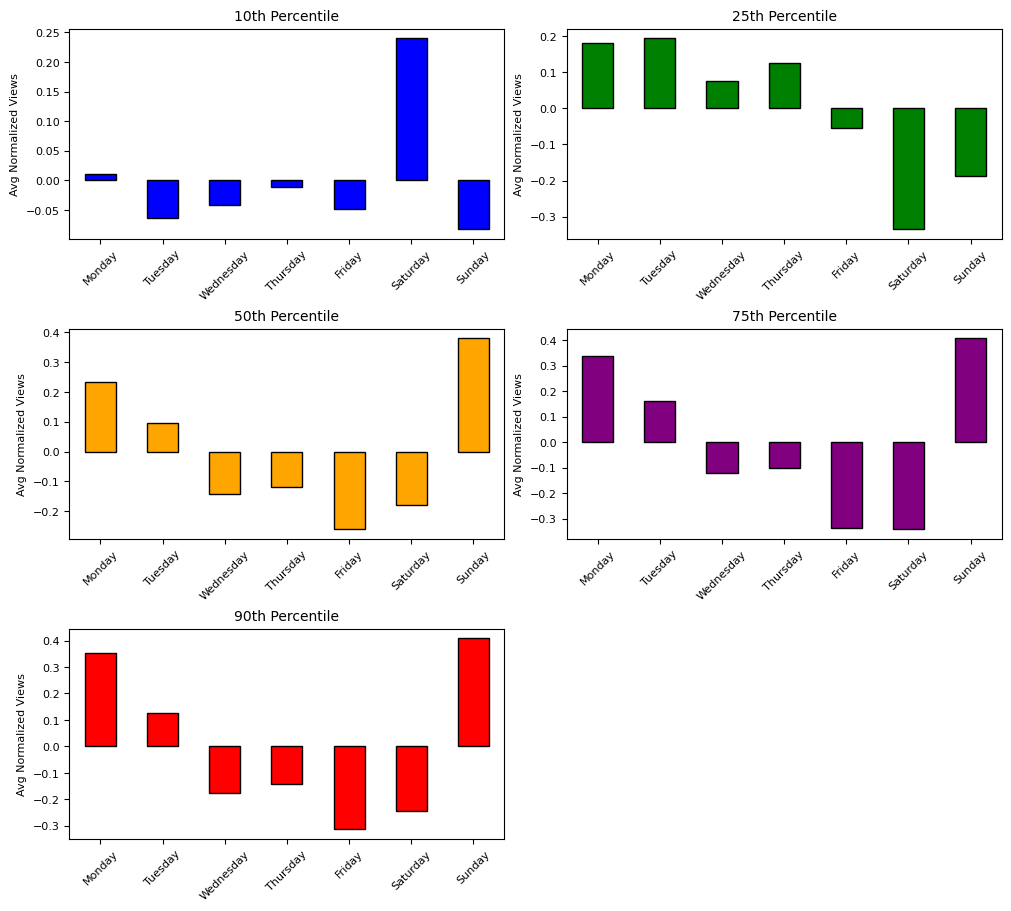

In [17]:
# Loop through each quantile and barplot the weekly counts (normalized)
n_rows = len(quantile_ts) // 2 + len(quantile_ts) % 2  # Calculate rows for a 2-column grid
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 3 * n_rows), constrained_layout=True)

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['blue', 'green', 'orange', 'purple', 'red']  # Colors for quantiles
axes = axes.flatten()  # Flatten axes for easy iteration

for ax, (quantile, ts), color in zip(axes, quantile_norm.items(), colors):
    # Extract the day of the week for each date
    day_of_week = ts.index.day_name()

    # Group the normalized time series by day of the week and calculate the mean
    day_of_week_means = ts.groupby(day_of_week).mean().reindex(ordered_days)

    # Plot the bar chart
    day_of_week_means.plot(kind='bar', color=color, edgecolor='black', ax=ax)
    ax.set_title(f'{int(quantile * 100)}th Percentile', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Avg Normalized Views', fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide any unused subplots
for ax in axes[len(quantile_norm):]:
    ax.axis('off')

plt.show()


## Building a Simple Forecasting Model

We now construct a baseline forecasting model based on insights from our initial exploratory data analysis (EDA).

### Overview

- The model generates **30-day forecasts** for each page individually.
- Forecasts are computed using the **median** of past observations for the **same day of the week**, leveraging the weekly seasonality identified earlier.
- We compute the median over a **120-day window**, motivated by the strong autocorrelation structure observed over that range.
- To quantify uncertainty, we assume page views follow a **memoryless Poisson process**, which allows us to derive confidence intervals for the forecasts.
- Finally, we evaluate this simple model on a held-out validation set to understand its strengths and limitations.

In [18]:
def forecast_median_past_30_day_blocks(ts, forecast_horizon=30, n_blocks=4):
    """
    For a given time series, find the last `n_blocks` 30-day windows aligned to the weekday of forecast start,
    and return the median across these windows as the forecast.

    Parameters:
        ts: pd.Series with datetime index
        forecast_horizon: number of days to forecast
        n_blocks: how many past aligned 30-day blocks to use

    Returns:
        pd.Series of forecasted values
    """
    ts = ts.dropna()
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise ValueError("Time series must have a datetime index")

    last_day = ts.index[-1]
    target_weekday = (last_day + pd.Timedelta(days=1)).weekday()
    forecast_index = pd.date_range(last_day + pd.Timedelta(days=1), periods=forecast_horizon)

    # Store valid windows
    valid_blocks = []

    for offset in range(7, len(ts) - forecast_horizon):
        start = -forecast_horizon - offset
        end = start + forecast_horizon
        block = ts.iloc[start:end]

        if len(block) == forecast_horizon and block.index[0].weekday() == target_weekday:
            valid_blocks.append(block.values)
            if len(valid_blocks) == n_blocks:
                break

    if not valid_blocks:
        raise ValueError("No aligned 30-day blocks found in time series.")

    block_matrix = np.vstack(valid_blocks)
    median_forecast = np.median(block_matrix, axis=0)

    return pd.Series(median_forecast, index=forecast_index)


### Modelling Forecast Uncertainty

We assume that page views arise **independently** each day according to a Poisson process with a fixed daily rate. That is, for each day $t$, the number of views $Y_t$ is drawn from a Poisson distribution:

$$
Y_t \sim \text{Poisson}(\lambda_t)
$$

This means that:
- Page views are **independent across days**,
- The expected number of views is $\lambda_t$,
- The **distribution of page counts** is given by:

$$
P(Y_t = k) = \frac{\lambda_t^k e^{-\lambda_t}}{k!}, \quad k = 0, 1, 2, \dots
$$

Under this model, the **mean and variance** of the page counts are both equal to $\lambda_t$, allowing us to construct uncertainty intervals directly from the Poisson distribution.

This simple assumption provides a reasonable starting point for modelling uncertainty.


We now assess the model’s performance on a set of representative pages exhibiting varying levels of overall activity.


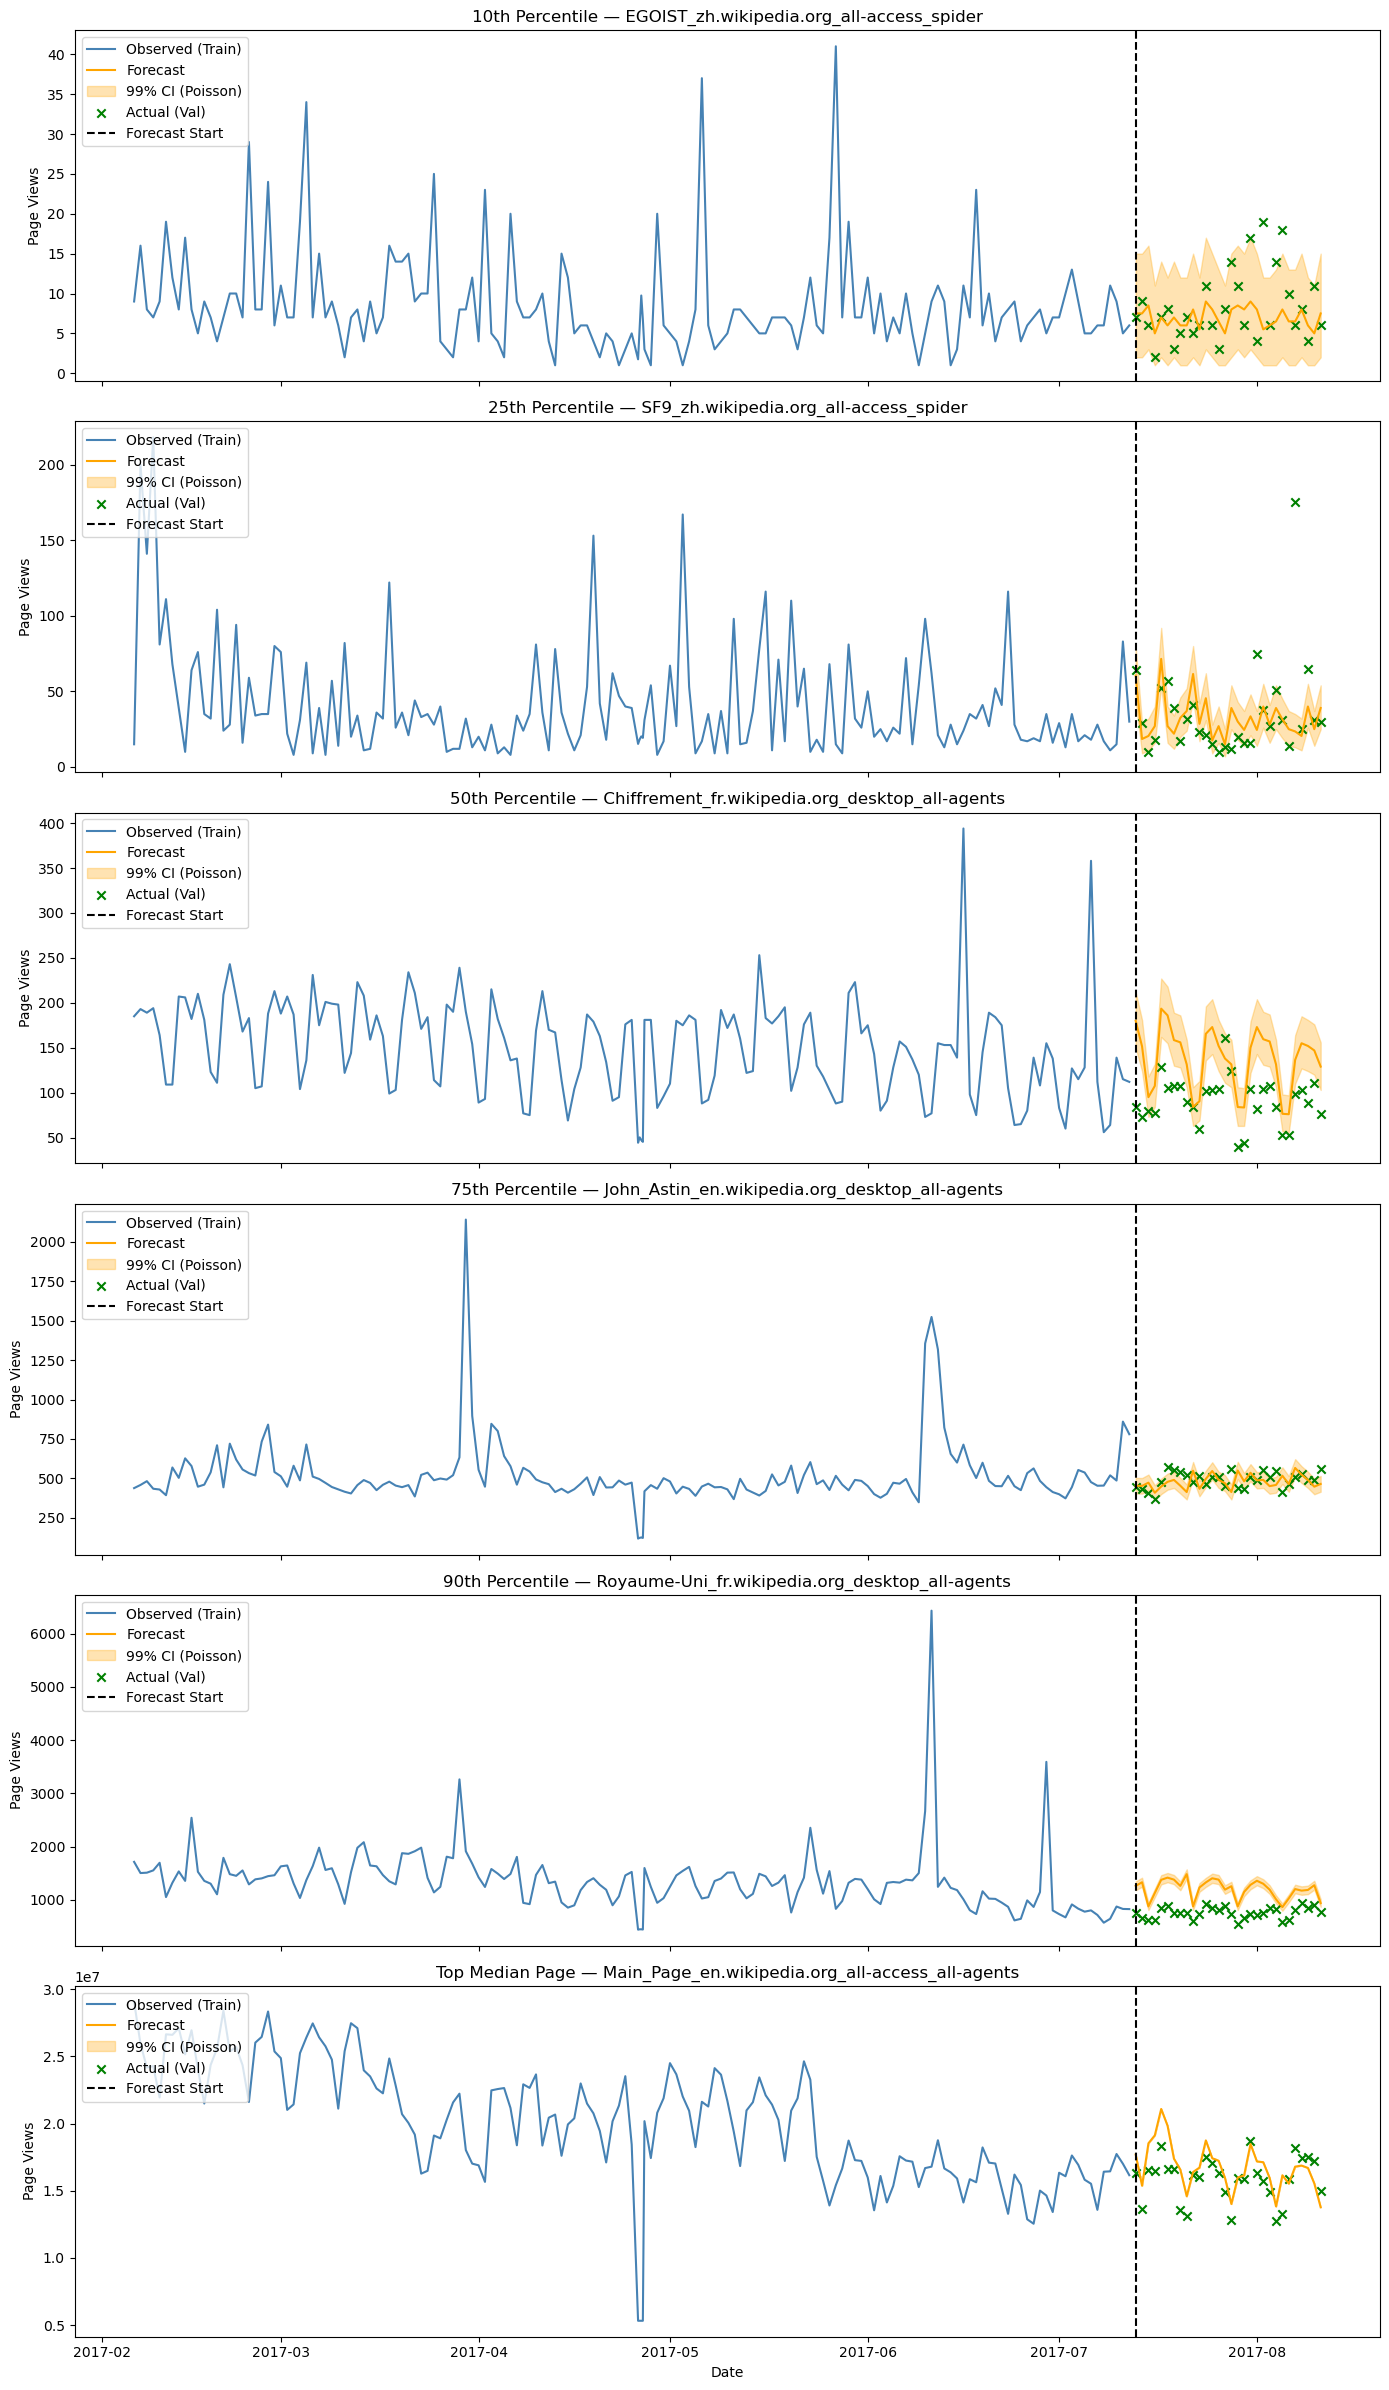

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

# --- Step 1: Compute median view count per page ---
page_medians = train_df.median(axis=1)
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_values = page_medians.quantile(quantiles)

# --- Step 2: Find closest matching pages for each quantile ---
selected_pages = []
quantile_labels = []
for q, qv in zip(quantiles, quantile_values):
    closest_page = (page_medians - qv).abs().idxmin()
    selected_pages.append(closest_page)
    quantile_labels.append(f"{int(q*100)}th Percentile")

# --- Step 3: Add page with highest median views ---
top_page = page_medians.idxmax()
if top_page not in selected_pages:
    selected_pages.append(top_page)
    quantile_labels.append("Top Median Page")

# --- Step 4: Subplots ---
fig, axes = plt.subplots(len(selected_pages), 1, figsize=(14, 4 * len(selected_pages)), sharex=True)

for i, (page_name, label) in enumerate(zip(selected_pages, quantile_labels)):
    ax = axes[i] if len(selected_pages) > 1 else axes

    page_ts = train_df.loc[page_name].dropna()

    # Split into train and val
    val = page_ts[-30:]
    train = page_ts[:-30]

    # Forecast
    forecast = forecast_median_past_30_day_blocks(train, forecast_horizon=30, n_blocks=4)

    # Poisson uncertainty
    lower = np.clip(poisson.ppf(0.01, forecast), a_min=0, a_max=None)
    upper = poisson.ppf(0.99, forecast)

    # Plot
    ax.plot(train[-160:], color='steelblue', label='Observed (Train)')
    ax.plot(forecast.index, forecast.values, color='orange', label='Forecast')
    ax.fill_between(forecast.index, lower, upper, color='orange', alpha=0.3, label='99% CI (Poisson)')
    ax.scatter(val.index, val.values, color='green', marker='x', label='Actual (Val)')

    ax.axvline(forecast.index[0], color='black', linestyle='--', label='Forecast Start')
    ax.set_title(f"{label} — {page_name}")
    ax.set_ylabel("Page Views")
    ax.legend(loc='upper left')

plt.xlabel("Date")
plt.tight_layout()
plt.show()


### Key Insights from Validating the Simple Model

Our initial evaluation of the simple model reveals several important takeaways:

- **Strong Seasonal Capture:** The model effectively captures weekly seasonality, especially for pages with stable viewing patterns.
- **Surprisingly Competitive Performance:** Despite its simplicity, the model performs reasonably well across a range of page types.
- **Trend Limitations:** Some forecasts appear consistently offset—this suggests the model fails to account for underlying trends in page views.
- **Underestimated Uncertainty:** The assumption of Poisson-distributed errors leads to overly narrow confidence intervals for high-traffic pages, indicating underestimated variance.


### Tuning Forecast Uncertainty

To capture the underdispersion observed at higher page counts, we revise our assumptions about how page views are generated.

We continue to assume that **daily page views are independent**, and follow a **Poisson distribution** with rate $\lambda_t$:

$$
Y_t \mid \lambda_t \sim \text{Poisson}(\lambda_t)
$$

However, we now further assume that $\lambda_t$ itself is not fixed, but is instead drawn from a **random distribution**, allowing for uncertainty in the page’s latent popularity:

$$
\lambda_t \sim \text{Gamma}(r, \theta)
$$

As a result, the marginal distribution of $Y_t$ becomes a **Negative Binomial distribution**:

$$
Y_t \sim \text{NegativeBinomial}(\lambda_t, \alpha)
$$

This change reflects our belief that page view rates can vary from day to day, even if the expected average remains constant. The additional parameter $\alpha$ controls the dispersion — higher values yield wider confidence intervals, especially useful for higher-volume pages where Poisson intervals are too narrow.

We'll begin by visually tuning the uncertainty estimates (by tuning $\alpha$) on the page with the highest overall activity — the main Wikipedia page — to better calibrate our confidence intervals. Of course a more comprehensive approach might tune this across the whole dataset or for each page individually.


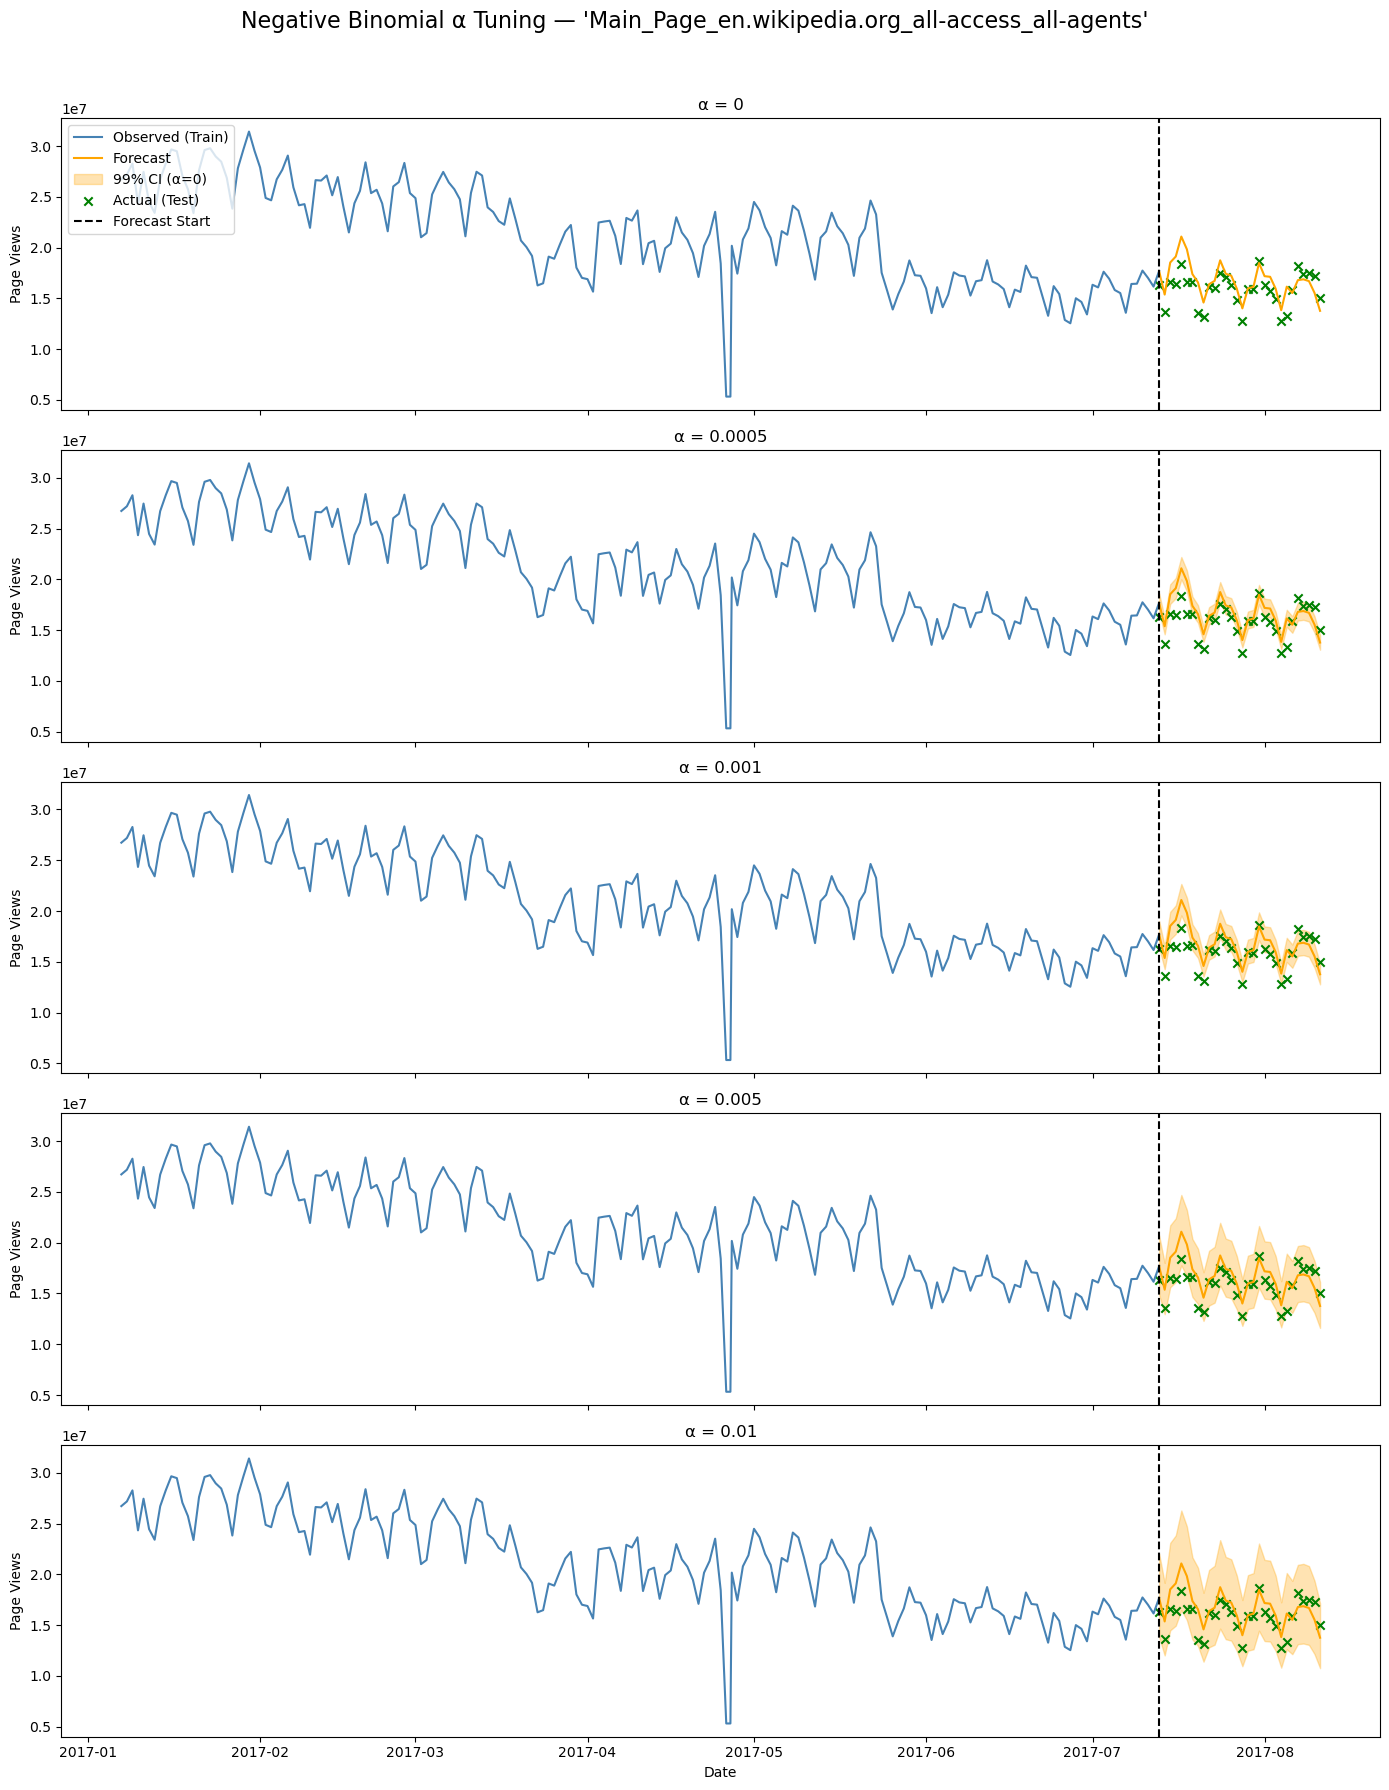

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import nbinom

# --- Utilities ---
def neg_binomial_interval(forecast, alpha=0.00005, q_low=0.01, q_high=0.99):
    """
    Compute Negative Binomial quantiles for forecast values.

    forecast: pd.Series or np.array of mean values (λ)
    alpha: dispersion parameter (0 = Poisson)
    q_low, q_high: quantiles (e.g. 0.01, 0.99)

    Returns: lower and upper arrays
    """
    mu = np.array(forecast)
    var = mu + alpha * mu**2

    # Compute NB parameters r, p
    r = mu**2 / (var - mu)
    p = r / (r + mu)

    # Compute quantiles
    lower = nbinom.ppf(q_low, r, p)
    upper = nbinom.ppf(q_high, r, p)

    return np.clip(lower, a_min=0, a_max=None), upper

# --- Page selection ---
page_name = train_df.median(axis=1).idxmax()

# --- Time series prep ---
page_ts = train_df.loc[page_name]
val = page_ts[-30:]
train = page_ts[:-30]

# Forecast using the simple median-block model
forecast = forecast_median_past_30_day_blocks(train, forecast_horizon=30, n_blocks=4)


# History segments
joined_series = pd.concat([train[-190:], forecast])
forecast_start = forecast.index[0]
observed_segment = joined_series[:forecast_start]
forecast_segment = joined_series[forecast_start:]

# --- Alpha tuning ---
alpha_values = [0, 0.0005, 0.001, 0.005, 0.01]

fig, axes = plt.subplots(len(alpha_values), 1, figsize=(14, 3.5 * len(alpha_values)), sharex=True)

for i, alpha in enumerate(alpha_values):
    ax = axes[i]

    lower, upper = neg_binomial_interval(forecast.values, alpha=alpha)

    ax.plot(observed_segment.index, observed_segment.values, color='steelblue', label='Observed (Train)')
    ax.plot(forecast_segment.index, forecast_segment.values, color='orange', label='Forecast')
    ax.fill_between(forecast.index, lower, upper, color='orange', alpha=0.3, label=f"99% CI (α={alpha})")
    ax.scatter(val.index, val.values, color='green', marker='x', label='Actual (Test)')

    ax.axvline(forecast_start, color='black', linestyle='--', label='Forecast Start' if i == 0 else None)
    ax.set_title(f"α = {alpha}")
    ax.set_ylabel("Page Views")

    if i == 0:
        ax.legend(loc='upper left')

plt.xlabel("Date")
plt.suptitle(f"Negative Binomial α Tuning — '{page_name}'", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Visually it looks like $\alpha = 0.005$ provides a better estimate of the uncertainty at the top end of page counts.

Let's see if this also works with the whole spectrum of pages.

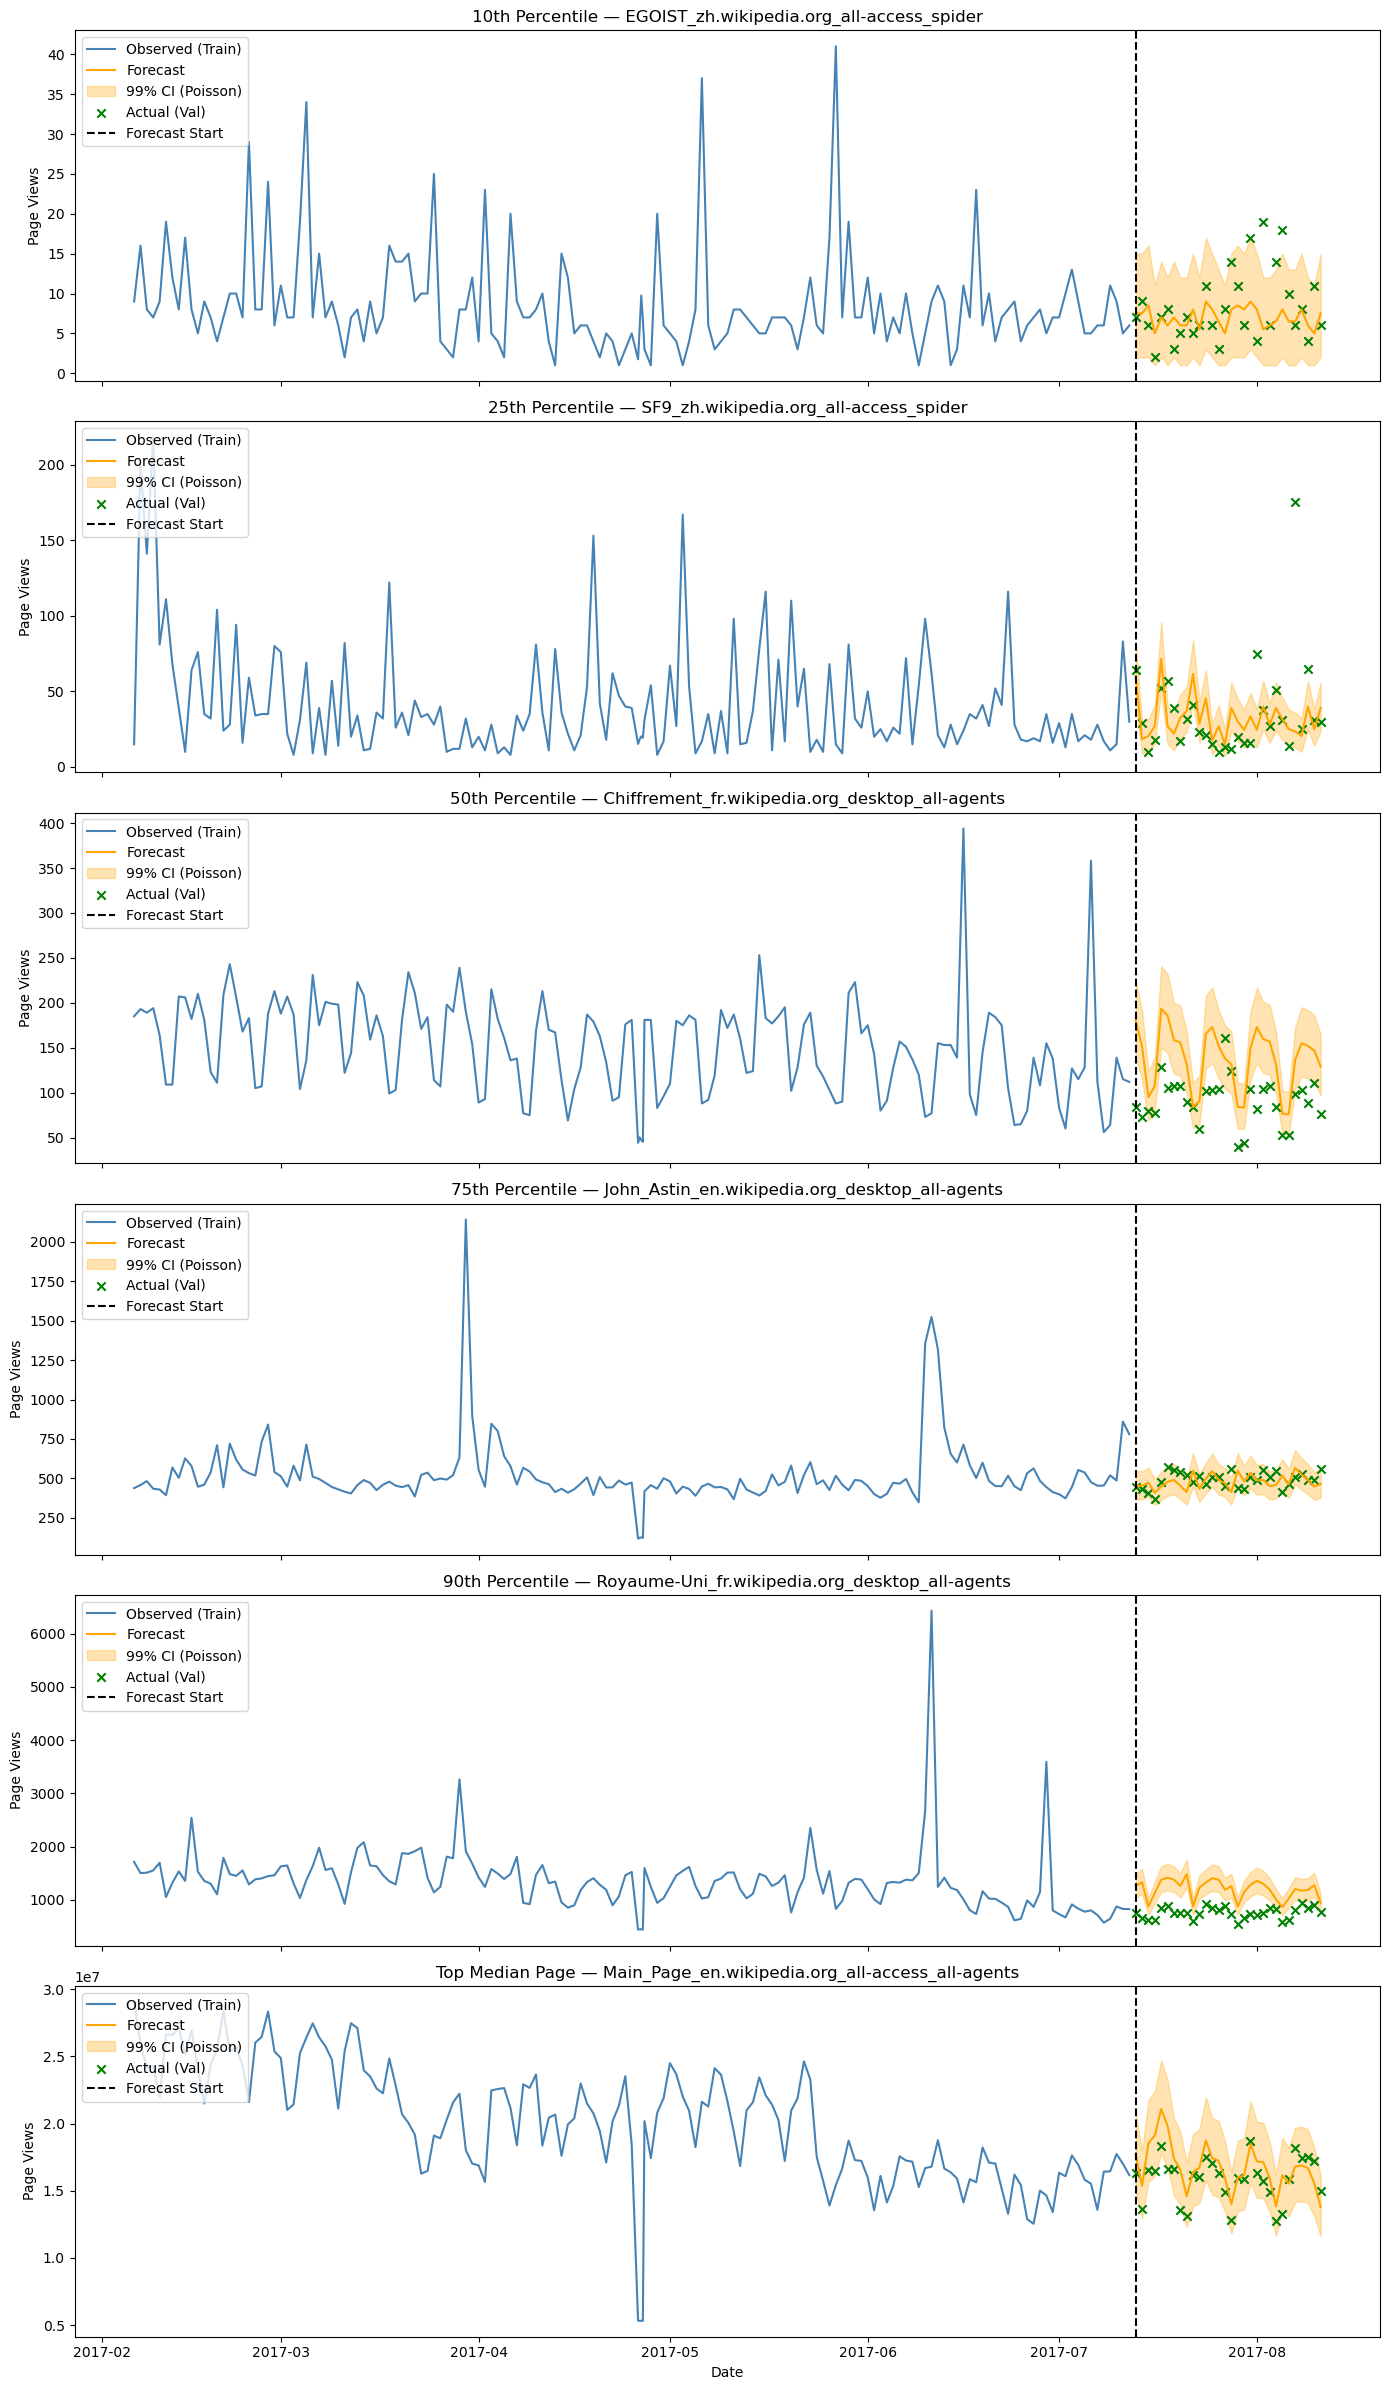

In [21]:
fig, axes = plt.subplots(len(selected_pages), 1, figsize=(14, 4 * len(selected_pages)), sharex=True)

for i, (page_name, label) in enumerate(zip(selected_pages, quantile_labels)):
    ax = axes[i] if len(selected_pages) > 1 else axes

    # Select time series
    page_ts = train_df.loc[page_name].dropna()

    # Split into train and val
    val = page_ts[-30:]
    train = page_ts[:-30]

    # Forecast
    forecast = forecast_median_past_30_day_blocks(train, forecast_horizon=30, n_blocks=4)

    # Negative Binomial uncertainty with alpha=0.005
    lower, upper = neg_binomial_interval(forecast.values, alpha=0.005)

    # Plot
    ax.plot(train[-160:], color='steelblue', label='Observed (Train)')
    ax.plot(forecast.index, forecast.values, color='orange', label='Forecast')
    ax.fill_between(forecast.index, lower, upper, color='orange', alpha=0.3, label='99% CI (Poisson)')
    ax.scatter(val.index, val.values, color='green', marker='x', label='Actual (Val)')

    ax.axvline(forecast.index[0], color='black', linestyle='--', label='Forecast Start')
    ax.set_title(f"{label} — {page_name}")
    ax.set_ylabel("Page Views")
    ax.legend(loc='upper left')

plt.xlabel("Date")
plt.tight_layout()
plt.show()


The Negative Binomial model provides visibly better-calibrated uncertainty estimates for these pages, particularly at higher page counts. Of course the model still appears to missfit the trend sometimes, which we will improve upon with our better model.

However, based on this (very!) quick visual inspection, we will proceed with this approach for our uncertainty modelling.

### Investigating Cross-Page Predictive Performance

Some pages exhibit more "spiky" behaviour than others — where sudden surges in page views are triggered by external events not represented in the historical data. 

For example, the release of a new season of *Black Mirror* can cause a sharp increase in traffic across multiple related pages, presenting a challenge for individual time series models.

Text(0.5, 1.0, 'Black_Mirror_en.wikipedia.org_all-access_all-agents')

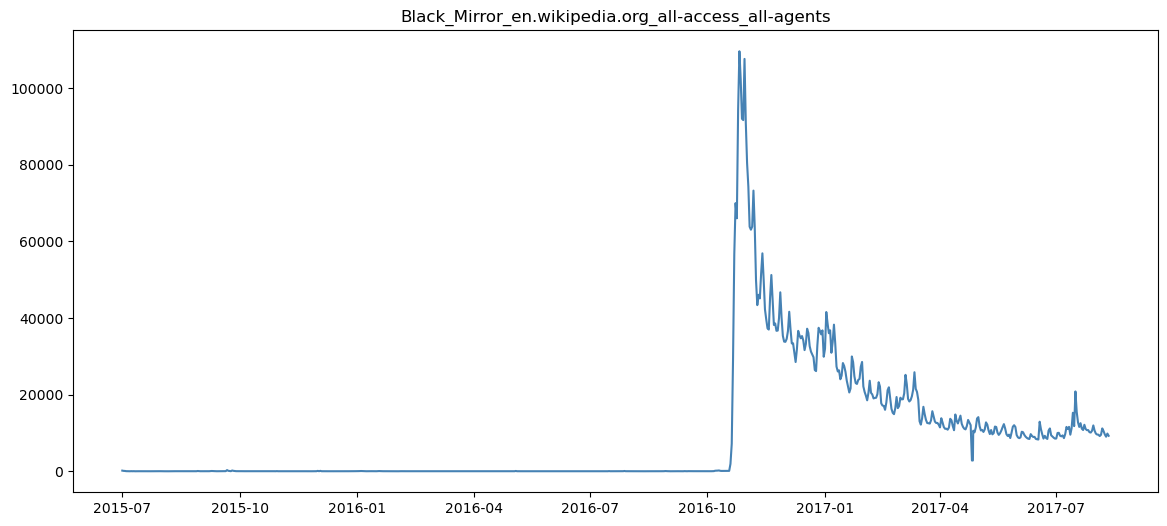

In [22]:
# plot this page Black_Mirror_en.wikipedia.org_all-access_all-agents 
page_name = 'Black_Mirror_en.wikipedia.org_all-access_all-agents'
page_ts = train_df.loc[page_name].dropna()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(page_ts, color='steelblue', label='Observed (Train)')
ax.set_title(f"{page_name}")

Whilst individual time series themselves might not contain information of an increase, this information might be contained in other "similar" time series.

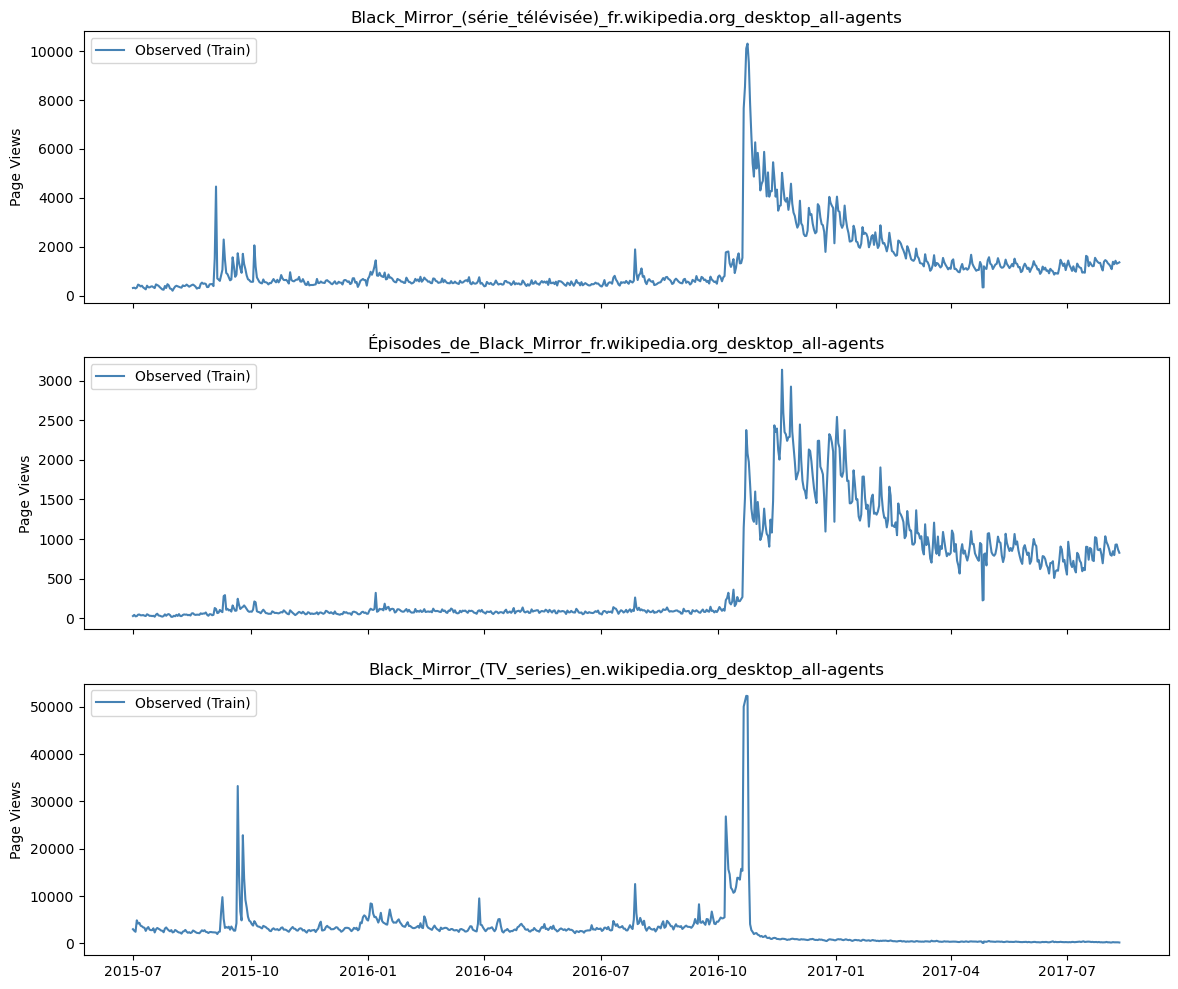

In [23]:
# first 3 pages with 'Black_Mirror' in the name
page_mask = train_df.index[train_df.index.str.contains('Black_Mirror', case=False)][:3]
page_df = train_df.loc[page_mask]

# plot subplots of each ts
fig, axes = plt.subplots(len(page_df), 1, figsize=(14, 4 * len(page_df)), sharex=True)
for i, (page_name, page_ts) in enumerate(page_df.iterrows()):
    ax = axes[i] if len(page_df) > 1 else axes

    # Plot
    ax.plot(page_ts, color='steelblue', label='Observed (Train)')
    ax.set_title(f"{page_name}")
    ax.set_ylabel("Page Views")
    ax.legend(loc='upper left')

We observe that all three time series experience a sudden spike, likely driven by the same external event. Notably, the third series exhibits this spike slightly earlier than the others.

This suggests a potential predictive relationship that could be exploited to improve forecasting performance — particularly for events not easily captured by univariate models. Let's explore how we might leverage this structure.


## Investigating Temporal Interactions Between Related Pages

We analyse temporal interactions between related Wikipedia pages (seperated by our 30 day forecast horizon) using two complementary tools:

### 1. **Granger Causality Test**

The Granger causality test assesses whether the **past values** of one time series $X$ provide **statistically significant predictive power** for another series $Y$, **after accounting for $Y$'s own history**.

We apply the test to all pairs of selected pages using a fixed lag of $L = 30$ days, motivated by our 30-day forecast horizon. The test compares two models:

- **Restricted model** (only $Y$'s lags):

  $$
  Y_t = \alpha + \sum_{i=1}^{L} \beta_i Y_{t-i} + \varepsilon_t
  $$

- **Unrestricted model** (includes lags of $X$):

  $$
  Y_t = \alpha + \sum_{i=1}^{L} \beta_i Y_{t-i} + \sum_{j=1}^{L} \gamma_j X_{t-j} + \varepsilon'_t
  $$

We test whether the coefficients $\gamma_j$ are jointly zero using an **F-test**. The resulting **p-value** tells us whether $X$ Granger-causes $Y$:

- Low p-value (e.g., $p < 0.05$) → $X$ is likely to Granger-cause $Y$
- High p-value → no evidence of predictive influence

We visualise the results in a heatmap of p-values, where darker cells indicate stronger potential causal effects.


### 2. **Residual Correlation (Controlling for Autocorrelation)**

Even if $X$ does not Granger-cause $Y$ at lag 30, it may still explain variation in $Y$’s **residuals**, i.e., deviations from its expected value given its own history.

We perform the following steps:

- Fit an autoregressive model for $Y$:

  $$
  \hat{Y}_t = \theta_0 + \theta_1 Y_{t-L}
  $$

- Compute the residuals:

  $$
  r_t = Y_t - \hat{Y}_t
  $$

- Measure the Pearson correlation between the residuals and $X_{t-L}$:

  $$
  \text{corr}(r_t, X_{t-L})
  $$

This captures **indirect or latent interactions**: how one page may be related to another’s "surprises" after controlling for its own autocorrelation and trend.

In [24]:
def plot_granger_and_residual_heatmaps(df, keywords=["Black_Mirror"], lag=30):
    """
    Computes and visualizes Granger causality p-values and residual correlations
    for all time series whose page name contains any of the given keywords.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame of shape [n_pages, n_days] with datetime columns and page names as index.

    keywords : list of str
        List of substrings used to select relevant pages for analysis.

    lag : int
        Lag (in days) to use for Granger causality and residual correlation tests.

    Returns:
    --------
    None. Displays two side-by-side heatmaps:
        - Granger causality p-values
        - Residual correlations (controlling for autocorrelation)
    """
    # Combine all matching pages for the given keywords
    ordered_pages = []
    for keyword in keywords:
        matches = df.index[df.index.str.contains(keyword, case=False)]
        ordered_pages.extend([p for p in matches if p not in ordered_pages])  # keep unique order

    ts_dict = {}

    # --- Normalize time series ---
    for page in ordered_pages:
        ts = df.loc[page].dropna()
        if ts.std() > 0:
            ts_norm = (ts - ts.mean()) / ts.std()
            ts_dict[page] = ts_norm

    ts_df = pd.DataFrame(ts_dict).dropna()
    pages = ts_df.columns

    # truncate the column names from the string 'wikipedia' onwards for plotting later
    original_pages = ts_df.columns.tolist()
    display_names = [page.split('wiki')[0] for page in original_pages]

    # --- Initialize matrices ---
    pval_matrix = pd.DataFrame(index=pages, columns=pages, dtype=float)
    resid_corr_matrix = pd.DataFrame(index=pages, columns=pages, dtype=float)

   # --- Loop through each pair of pages ---
    for target in pages:
        for predictor in pages:

            # don't compare the same page
            if target == predictor:
                pval_matrix.loc[target, predictor] = np.nan
                resid_corr_matrix.loc[target, predictor] = np.nan
                continue

            # Shift series by lag 
            B = ts_df[target]
            A_lag = ts_df[predictor].shift(lag).rename("A_lag")
            B_lag = B.shift(lag).rename("B_lag")
            df_joined = pd.concat([B, B_lag, A_lag], axis=1).dropna()


            # --- (a) Granger Causality p-value ---
            try:
                data = pd.concat([ts_df[target], ts_df[predictor]], axis=1)
                data.columns = ['target', 'predictor']
                result = grangercausalitytests(data, [lag], verbose=False)
                # Store p-value of F-test for lag 30
                pval = result[lag][0]['ssr_ftest'][1]
                pval_matrix.loc[target, predictor] = pval
            except Exception as e:
                pval_matrix.loc[target, predictor] = np.nan 

            # --- (b) Residual correlation ---
            try:
                model = LinearRegression().fit(df_joined[['B_lag']], df_joined[target])
                B_pred = model.predict(df_joined[['B_lag']])
                residuals = df_joined[target] - B_pred
                resid_corr = np.corrcoef(residuals, df_joined['A_lag'])[0, 1]
                resid_corr_matrix.loc[target, predictor] = resid_corr
            except Exception:
                resid_corr_matrix.loc[target, predictor] = np.nan

    # --- Plot both matrices side-by-side ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # --- truncate the column names ---
    for matrix in [pval_matrix, resid_corr_matrix]:
        matrix.columns = display_names
        matrix.index = display_names

    # --- plot the heatmaps ---
    # --- (a) Granger p-values
    sns.heatmap(pval_matrix.astype(float), cmap='viridis_r', ax=axes[0],
                square=True, cbar_kws={'label': f'p-value (Granger, lag={lag})'},
                xticklabels=True, yticklabels=True)
    axes[0].set_title(f'Granger Causality p-values\n("{keywords}" pages)')

    # --- (b) Residual correlations ---
    sns.heatmap(resid_corr_matrix.astype(float), cmap='coolwarm', center=0, ax=axes[1],
                square=True, cbar_kws={'label': f'Residual Corr (lag={lag})'},
                xticklabels=True, yticklabels=False)
    axes[1].set_title(f'Residual Correlations (Controlling Autocorr)\n("{keywords}" pages)')

    for ax in axes:
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()


We observe that pages related to the TV series *Black Mirror* exhibit strong predictive relationships with one another, even at a lag of 30 days. This suggests shared temporal dynamics, likely driven by common external events (e.g., new season releases) that impact multiple related pages simultaneously.

In contrast, pages unrelated to the topic — such as those about the country *WTC* — show little to no cross-page predictive power with the *Black Mirror* set, as expected.

Furthermore, more "static" pages (e.g., those less influenced by current events or popular culture) tend to exhibit weaker internal correlations and less temporal interdependence, reinforcing the idea that their dynamics are more stable and self-contained.


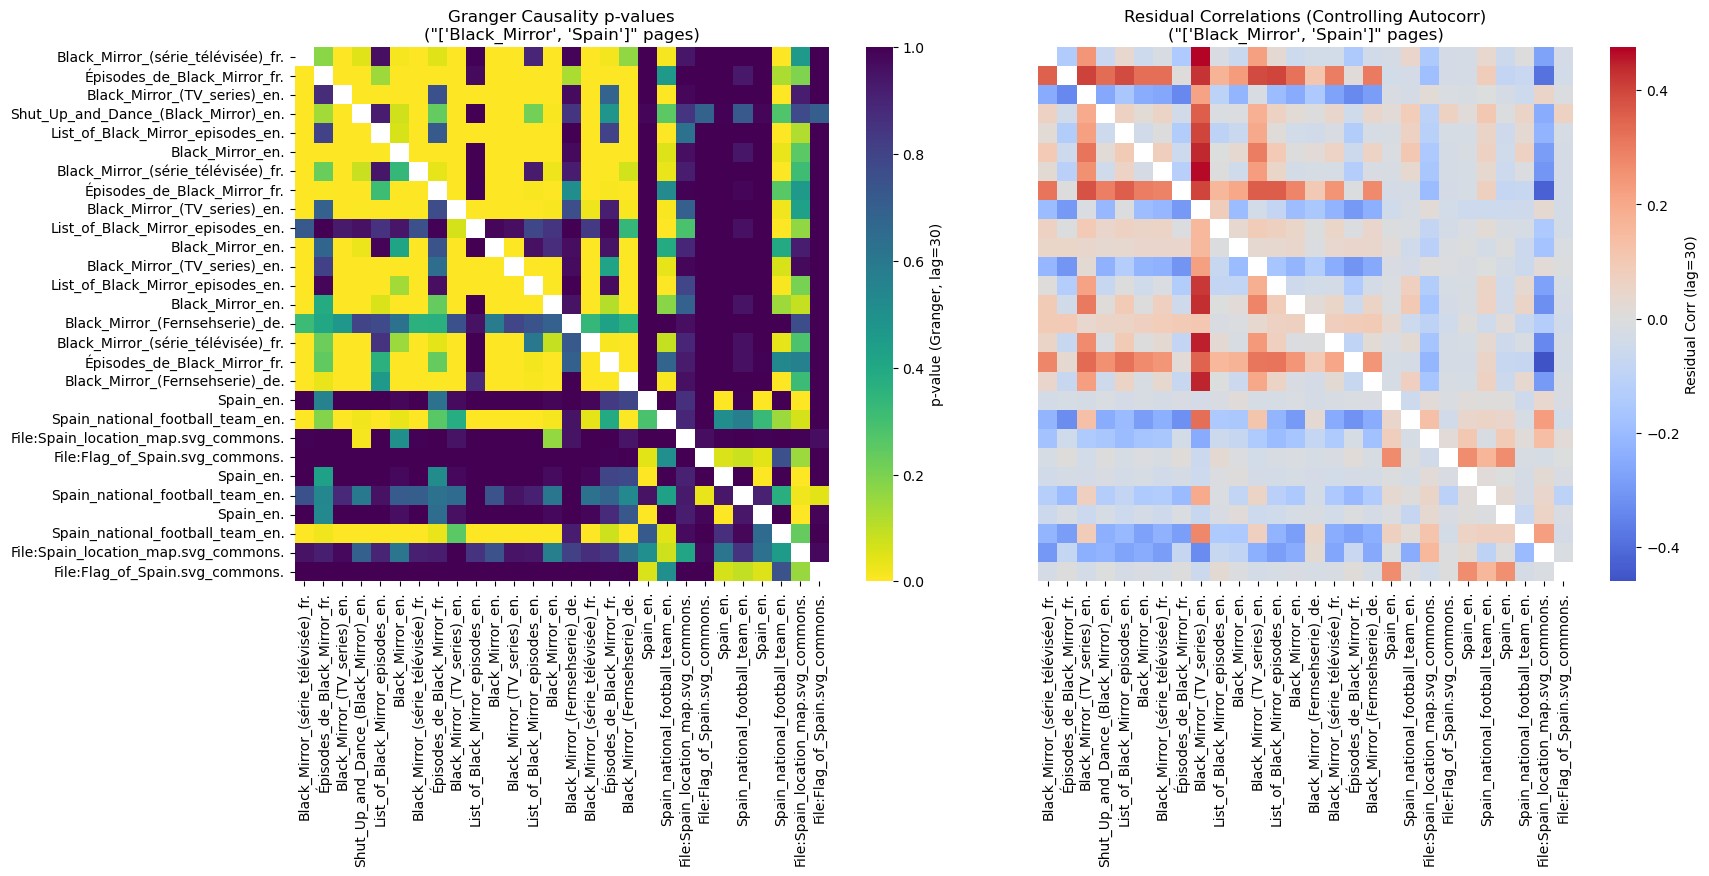

In [25]:
plot_granger_and_residual_heatmaps(train_df, keywords=["Black_Mirror", "Spain"], lag=30)

## Constructing an Improved Model

Based on insights gained from our exploratory analysis and the validation of the simple model, we now move to develop a more refined forecasting model.

The improved model will:
- **Leverage Seasonality**: Rather than discarding the simple model, we build upon it by modelling its **residuals** — effectively learning to correct its errors. This allows us to retain its strength in capturing weekly seasonality while addressing its limitations in capturing long-term trends.
- **Capture Uncertainty More Accurately**: We adopt a **Negative Binomial** distribution to model forecast uncertainty, which provides better coverage for high-count pages where the Poisson assumption underestimates variability.
- **Model Page Interactions**: We take a **multivariate approach** by clustering similar pages and jointly modelling their residuals. This allows us to share information across related pages and exploit the cross-page predictive relationships observed in the data.


### Clustering pages by similarity

Lets try and group the pages by their page title.

In [26]:
def extract_clean_title(page_str):
    """
    Extracts a clean, human-readable title from a Wikipedia page string.
    
    Parameters:
        page_str (str): Raw Wikipedia page identifier, typically formatted as 
                        'Page_Title_LANGCODE.wikipedia.org_ACCESS_PLATFORM'

    Returns:
        str: Cleaned title with underscores replaced by spaces, language/domain removed, 
             and known prefixes like 'File:' or 'Category:' stripped.
    """
    # Attempt to extract everything before the '_LANGCODE.wikipedia.org' part
    match = re.search(r'^(.*)_(\w+)\.wikipedia\.org', page_str)
    if match:
        title_raw = match.group(1)
    else:
        # Fallback for commons/wikimedia/other formats
        title_raw = re.split(r'_(?:wikipedia|wikimedia|commons)\.org', page_str)[0]

    # Remove prefixes like 'File:' or 'Category:'
    title_clean = re.sub(r'^File:|^Category:', '', title_raw)

    # Replace underscores with spaces and strip whitespace
    return title_clean.replace('_', ' ').strip()

Let's test our function of the "Black Mirror" pages.

In [27]:
# Example usage:
titles = train_df.index.to_series().apply(extract_clean_title)

# Test on titles that contain "Black Mirror"
print(titles[titles.str.contains('Black Mirror', case=False)].values)

['Black Mirror (série télévisée)' 'Épisodes de Black Mirror'
 'Black Mirror (TV series)' 'Shut Up and Dance (Black Mirror)'
 'List of Black Mirror episodes' 'Black Mirror'
 'Black Mirror (série télévisée)' 'Épisodes de Black Mirror'
 'Black Mirror (TV series)' 'List of Black Mirror episodes' 'Black Mirror'
 'Black Mirror (TV series)' 'List of Black Mirror episodes' 'Black Mirror'
 'Black Mirror (Fernsehserie)' 'Black Mirror (série télévisée)'
 'Épisodes de Black Mirror' 'Black Mirror (Fernsehserie)']


Now that we’ve extracted the clean titles from the raw Wikipedia page identifiers, we can begin clustering semantically similar pages together.

To do this, we use the lightweight `SentenceTransformer('all-MiniLM-L6-v2')` model to embed each page title into a semantic vector space. These embeddings capture the contextual meaning of the titles, allowing us to apply a clustering algorithm to group together pages with related content.


In [28]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # fast & lightweight
embeddings = model.encode(titles.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/2007 [00:00<?, ?it/s]

Now we shall cluster the embedings using Kmeans.

In [29]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = int(len(titles)/10)  # average of 10 pages per cluster
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1024)
labels = kmeans.fit_predict(embeddings)

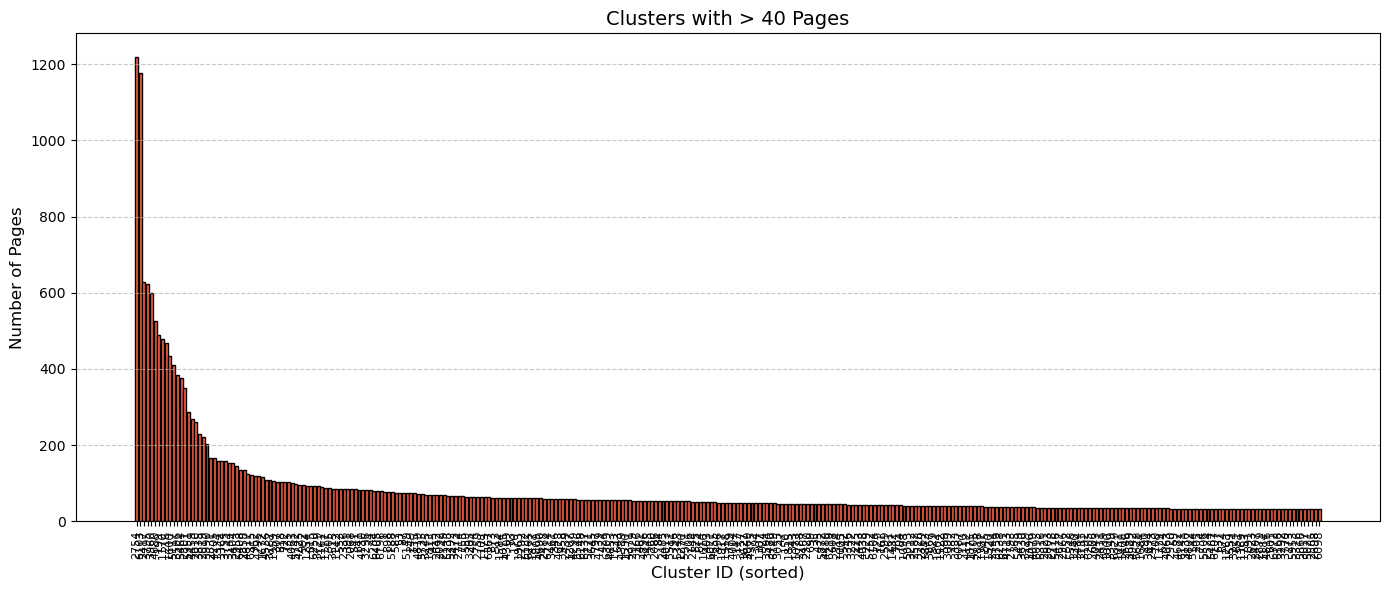

In [30]:
# Count pages per cluster
cluster_sizes = pd.Series(labels).value_counts()

# Filter clusters with > 40 pages
large_clusters = cluster_sizes[cluster_sizes > 30].sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(large_clusters)), large_clusters.values, color='tomato', edgecolor='black')

plt.title('Clusters with > 40 Pages', fontsize=14)
plt.xlabel('Cluster ID (sorted)', fontsize=12)
plt.ylabel('Number of Pages', fontsize=12)
plt.xticks(ticks=np.arange(len(large_clusters)), labels=large_clusters.index, rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Some clusters are significantly larger than others, which poses a challenge for multivariate time series modelling due to the high dimensionality. To maintain tractability and ensure balanced cluster sizes, we apply a simple heuristic to split larger clusters into smaller, more manageable groups (max 25).


In [31]:
def split_large_clusters(cluster_df, max_size=50):
    """
    Splits large clusters into smaller sub-clusters if the number of pages in a cluster exceeds the specified maximum size.
    """
    new_rows = []
    for cluster_id, group in cluster_df.groupby('cluster'):
        pages = group['Page'].tolist()
        if len(pages) > max_size:
            chunks = [pages[i:i + max_size] for i in range(0, len(pages), max_size)]
            for sub_id, chunk in enumerate(chunks):
                for page in chunk:
                    new_rows.append({'Page': page, 'cluster': f"{cluster_id}_{sub_id}"})
        else:
            for page in pages:
                new_rows.append({'Page': page, 'cluster': cluster_id})
    return pd.DataFrame(new_rows)

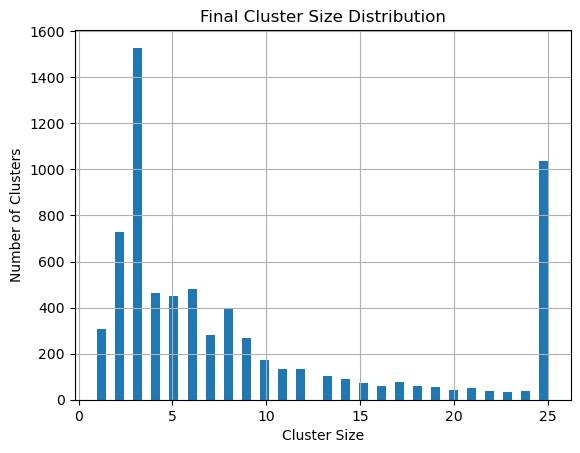

In [32]:
cluster_df = pd.DataFrame({'Page': train_df.index, 'title': titles, 'cluster': labels})
cluster_df = split_large_clusters(cluster_df, max_size=25)

# Make sure index names match
cluster_df = cluster_df.set_index('Page')

# Join cluster ID onto clean_train_df
train_df["cluster"] = train_df.index.map(cluster_df["cluster"])

cluster_df['cluster'].value_counts().hist(bins=50)
plt.title("Final Cluster Size Distribution")
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plt.show()

Let's evaluate the quality of our embedding and clustering by inspecting our example group of related pages — those associated with "Black Mirror".


In [33]:
# Filter pages containing "Black Mirror"
matching_pages = train_df.index[
    train_df.index.str.contains("Black_Mirror", case=False)
    ]

# Get the cluster ID for the first match
cluster_id = train_df.loc[matching_pages, "cluster"].unique()[0]
print("Cluster ID:", cluster_id)


cluster_page_names = train_df[train_df["cluster"] == cluster_id].index

print("Cluster Page Names:")
for page in cluster_page_names:
    print(page)

cluster_df = train_df.loc[cluster_page_names]


Cluster ID: 4657
Cluster Page Names:
Black_Mirror_(série_télévisée)_fr.wikipedia.org_desktop_all-agents
Épisodes_de_Black_Mirror_fr.wikipedia.org_desktop_all-agents
Black_Mirror_(TV_series)_en.wikipedia.org_desktop_all-agents
Shut_Up_and_Dance_(Black_Mirror)_en.wikipedia.org_desktop_all-agents
Black_Mirror_en.wikipedia.org_desktop_all-agents
Black_Mirror_(série_télévisée)_fr.wikipedia.org_all-access_all-agents
Épisodes_de_Black_Mirror_fr.wikipedia.org_all-access_all-agents
Black_Mirror_(TV_series)_en.wikipedia.org_all-access_spider
Black_Mirror_en.wikipedia.org_all-access_spider
Black_Mirror_(TV_series)_en.wikipedia.org_all-access_all-agents
Black_Mirror_en.wikipedia.org_all-access_all-agents
Black_Mirror_(Fernsehserie)_de.wikipedia.org_all-access_spider
Black_Mirror_(série_télévisée)_fr.wikipedia.org_mobile-web_all-agents
Épisodes_de_Black_Mirror_fr.wikipedia.org_mobile-web_all-agents
Black_Mirror_(Fernsehserie)_de.wikipedia.org_desktop_all-agents


## Constructing a Residual VAR Model for Each Cluster

We now build a residual Vector Autoregressive (VAR) model for each page cluster to improve our forecasts. The approach follows these steps:

1. **Generate Simple Model Forecasts** across the full training period using our earlier median-based approach.
2. **Compute Residuals** by subtracting these simple forecasts from the actual observed values.
3. **Fit a VAR Model** on the residuals within each cluster to learn temporal dependencies and cross-page corrections.

This approach allows us to preserve the strengths of the simple model (e.g., capturing seasonality), while learning systematic forecast errors — such as trend and cross-page influences — via the residual VAR model.


In [34]:
from joblib import Parallel, delayed

def generate_chunked_simple_forecast_df(df, forecast_horizon=30, n_blocks=5):
    """
    Generate forecasts using a simple rolling median model in 30-day blocks.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame of shape [n_pages, n_days + 1] (last column assumed non-date, e.g., cluster ID).
    forecast_horizon : int, default=30
        Number of days to forecast in each chunk.
    n_blocks : int, default=5
        Number of past 30-day blocks to use for the median.

    Returns
    -------
    forecast_df : pd.DataFrame
        Forecasts for each page, including in-sample chunks and a final 30-day forecast.
    """

    df = df.iloc[:, :-1].copy()
    df.columns = pd.to_datetime(df.columns)
    df = df.sort_index(axis=1)

    last_date = df.columns[-1]
    forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_horizon)
    extended_columns = df.columns.append(pd.DatetimeIndex(forecast_dates))

    forecast_df = pd.DataFrame(index=df.index, columns=extended_columns, dtype=float)

    def process_page(page_ts):
        page_ts = page_ts.dropna().sort_index()
        forecasts = {}

        i = forecast_horizon
        while i < len(page_ts):
            ts_past = page_ts.iloc[:i]
            try:
                forecast = forecast_median_past_30_day_blocks(ts_past, forecast_horizon, n_blocks)
                valid_range = page_ts.index[i:i + forecast_horizon]
                intersect = forecast.index.intersection(valid_range)
                forecasts.update(dict(zip(intersect, forecast[intersect])))
            except Exception:
                pass
            i += forecast_horizon

        try:
            final_forecast = forecast_median_past_30_day_blocks(page_ts, forecast_horizon, n_blocks)
            forecasts.update(dict(zip(forecast_dates, final_forecast)))
        except Exception:
            pass

        return pd.Series(forecasts)

    # Parallel processing
    forecast_series_list = Parallel(n_jobs=-1)(delayed(process_page)(df.loc[page]) for page in df.index)


    forecast_df.update(pd.DataFrame(forecast_series_list, index=df.index))
    return forecast_df

In [35]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

simple_model_forecast_df = generate_chunked_simple_forecast_df(
    train_df,
    forecast_horizon=30,
    n_blocks=4
)

We subtract the simple forecast from the observed data to give us the residuals.

In [36]:
residual_df = train_df - simple_model_forecast_df
#drop nans
residual_df = residual_df.dropna(axis=1, how='all')

Let's take a quick look at one of the residual time series. We can see that it fluctuates around zero, capturing deviations from the simple forecast. Notably, it exhibits some trend-like behaviour and occasional sharp spikes — likely driven by external events.

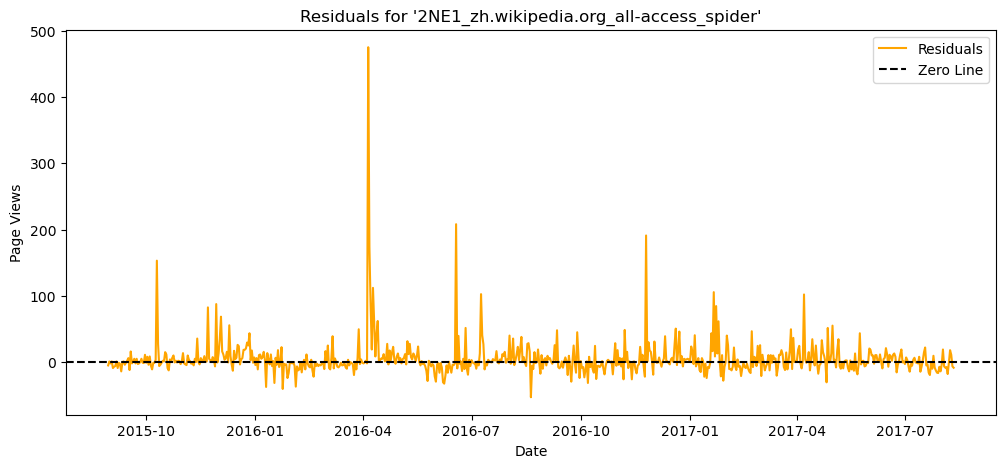

In [37]:
# plot one page of the residual_df
page_name = train_df.iloc[:100].index[0]
page_ts = train_df.iloc[:100].loc[page_name]
residual_ts = residual_df.loc[page_name].dropna()
forecast_ts = simple_model_forecast_df.loc[page_name].dropna()

# plot the residuals
plt.figure(figsize=(12, 5))
plt.plot(residual_ts.index, residual_ts.values, color='orange', label='Residuals')
plt.axhline(0, color='black', linestyle='--', label='Zero Line')
plt.title(f"Residuals for '{page_name}'")
plt.xlabel("Date")
plt.ylabel("Page Views")
plt.legend()
plt.show()

Another autocorrelation plot reveals a much weaker temporal structure: the residual series shows little to no seasonality and exhibits only short-term dependencies, with correlations decaying rapidly.


Text(0, 0.5, 'ACF')

<Figure size 1200x500 with 0 Axes>

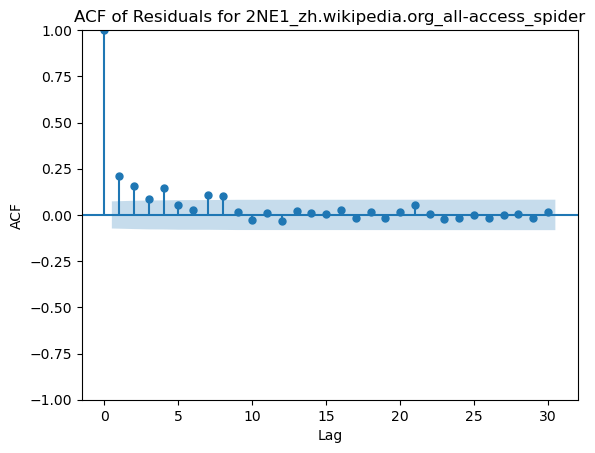

In [38]:
plt.figure(figsize=(12, 5))
plot_acf(residual_ts, lags=30)
plt.title(f'ACF of Residuals for {page_name}')
plt.xlabel('Lag')
plt.ylabel('ACF')   

## Defining a Residual VAR Model

We now define our improved model, which operates on the residuals of the simple forecasting model within a given cluster of related pages.

The rationale is as follows:
- The **simple model** captures strong seasonal patterns shared across most pages.
- However, it fails to adapt to **long-term trends** or **correlated dynamics** between pages in the same cluster.
- By modelling the **residuals** of the simple model (i.e. the difference between the actual values and the simple forecast), we aim to capture these missing components using a **Vector Autoregressive (VAR)** model.

### Model Details:
- We **smooth** and **clip** the residuals to suppress noise and extreme values that could destabilise training.
- We **fit a VAR model** to the most recent $N$ days of residuals (default 180) to capture recent dynamics and trends.
- We forecast forward using this model, and **add the predicted residuals back** to the simple model's forecast to obtain the final prediction.
- For forecasting uncertainty, we retain the Negative Binomial formulation tuned earlier.

### Mathematical Formulation

Let $$ \mathbf{r}_t \in \mathbb{R}^k $$ be the residual vector at time $t$, for $k$ pages in a cluster.  
We assume the residuals follow a VAR($p$) process:

$$
\mathbf{r}_t = \mathbf{c} + \sum_{i=1}^p \mathbf{A}_i \mathbf{r}_{t-i} + \boldsymbol{\varepsilon}_t
$$

where:
- $\mathbf{c}$ is a vector of constants (trend),
- $\mathbf{A}_i$ are autoregressive coefficient matrices,
- $\boldsymbol{\varepsilon}_t \sim \mathcal{N}(0, \Sigma)$ is white noise.

We forecast future residuals $\hat{\mathbf{r}}_{t+h}$ and add them to the simple forecast $\hat{\mathbf{y}}_{t+h}^{\text{simple}}$ to obtain:

$$
\hat{\mathbf{y}}_{t+h} = \hat{\mathbf{y}}_{t+h}^{\text{simple}} + \hat{\mathbf{r}}_{t+h}
$$

### Forecast Distribution

To model uncertainty in the forecasts, we assume the observed page counts $Y_t$ follow a **Negative Binomial distribution**:

$$
Y_t \sim \text{NegBin}(\lambda_t, \alpha)
$$

where:
- $\lambda_t$ is the mean forecasted value from the model,
- $\alpha = 0.005$ controls the dispersion: higher $\alpha$ implies higher variance.

This choice reflects underdispersion commonly observed in high-count Poisson-like data and allows more flexible confidence intervals than the pure Poisson model.


In [39]:
from statsmodels.tsa.api import VAR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def forecast_residuals_with_VAR(residual_df, cluster_page_names=None, forecast_horizon=30, smooth_window=14,
                                clip_range=(-1, 1), recent_days=180, trend='c', maxlags=1, plot=False):
    """
    Forecast future residuals using a smoothed and clipped VAR model. Optionally plots smoothed residuals and forecasts.

    Parameters:
    -----------
    residual_df : pd.DataFrame
        Residual time series of shape [n_pages, n_days].
    cluster_page_names : list of str, optional
        List of page names to plot. Required if plot=True.
    forecast_horizon : int, optional
        Number of days to forecast. Default is 30.
    smooth_window : int, optional
        Rolling mean window size for smoothing. Default is 14.
    clip_range : tuple, optional
        Min and max values to clip the normalised residuals to. Default is (-1, 1).
    recent_days : int, optional
        Number of most recent days to use for model fitting. Default is 180.
    trend : str, optional
        Trend term for VAR model ('n', 'c', 'ct', 'ctt'). Default is 'ctt'.
    maxlags : int, optional
        Maximum lag order for VAR model. Default is 1.
    plot : bool, optional
        Whether to generate a plot of the smoothed residuals and forecast. Default is False.

    Returns:
    --------
    forecasted_residuals_df : pd.DataFrame
        Forecasted residuals for the next `forecast_horizon` days with datetime index.
    """
    # 1. Transpose and drop NaNs
    residual_df = residual_df[residual_df.index.isin(cluster_page_names)].copy()

    residual_df_T = residual_df.T.dropna()

    # 2. Normalize
    means = residual_df_T.mean()
    stds = residual_df_T.std().replace(0, 1)
    residuals_norm = (residual_df_T - means) / stds

    # 3. Clip to avoid extreme values
    residuals_norm = residuals_norm.clip(*clip_range)

    # 4. Smooth with rolling average
    residuals_smooth = residuals_norm.rolling(window=smooth_window, center=True, min_periods=1).mean()

    # 5. Use most recent days
    residuals_recent = residuals_smooth.iloc[-recent_days:]

    # 6. Fit VAR model
    try:
        var_model = VAR(residuals_recent)
        fitted_var = var_model.fit(ic='aic', trend=trend, maxlags=maxlags)
    except ValueError as e:
        return pd.DataFrame(0, index=pd.date_range(residual_df_T.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon), columns=residual_df_T.columns)
    
    lag_order = fitted_var.k_ar

    # 7. Forecast
    last_obs = residuals_recent.values[-lag_order:]
    forecasted_residuals_norm = fitted_var.forecast(last_obs, steps=forecast_horizon)

    # 8. Denormalize
    forecasted_residuals = forecasted_residuals_norm * stds.values + means.values

    # 9. Build forecast DataFrame
    forecast_dates = pd.date_range(residual_df_T.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
    forecasted_residuals_df = pd.DataFrame(forecasted_residuals, index=forecast_dates, columns=residual_df_T.columns)

    # === Optional Plotting ===
    if plot:
        if cluster_page_names is None:
            raise ValueError("You must provide `cluster_page_names` if plot=True.")

        residuals_smooth_unnorm = residuals_smooth * stds.values + means.values

        n_pages = len(cluster_page_names)
        fig, axes = plt.subplots(4, 1, figsize=(12, 3 * 4), sharex=True)

        for i, page in enumerate(cluster_page_names):
            if i == 4:
                break
            ax = axes[i] if n_pages > 1 else axes
            ax.plot(residual_df_T[page][-200:], label=f"{page} (Residuals)", color='gray', alpha=0.5)
            ax.plot(residuals_smooth_unnorm[page][-200:], label=f"{page} (Smoothed)", color='steelblue')
            ax.plot(forecasted_residuals_df[page], label=f"{page} (Forecast)", linestyle='--', color='orange')
            ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
            ax.set_title(f"Residuals, Smoothed Trend, and Forecast for {page}")
            ax.legend()


        plt.tight_layout()
        plt.show()

    return forecasted_residuals_df


Let's examine how a fitted VAR model forecasts the residuals for pages within the *Black Mirror* cluster. To reduce high-frequency noise that might hinder model performance, we've applied a smoothing operation to the residual time series before fitting.


It seems to be projecting the trend in a reasonable manner.

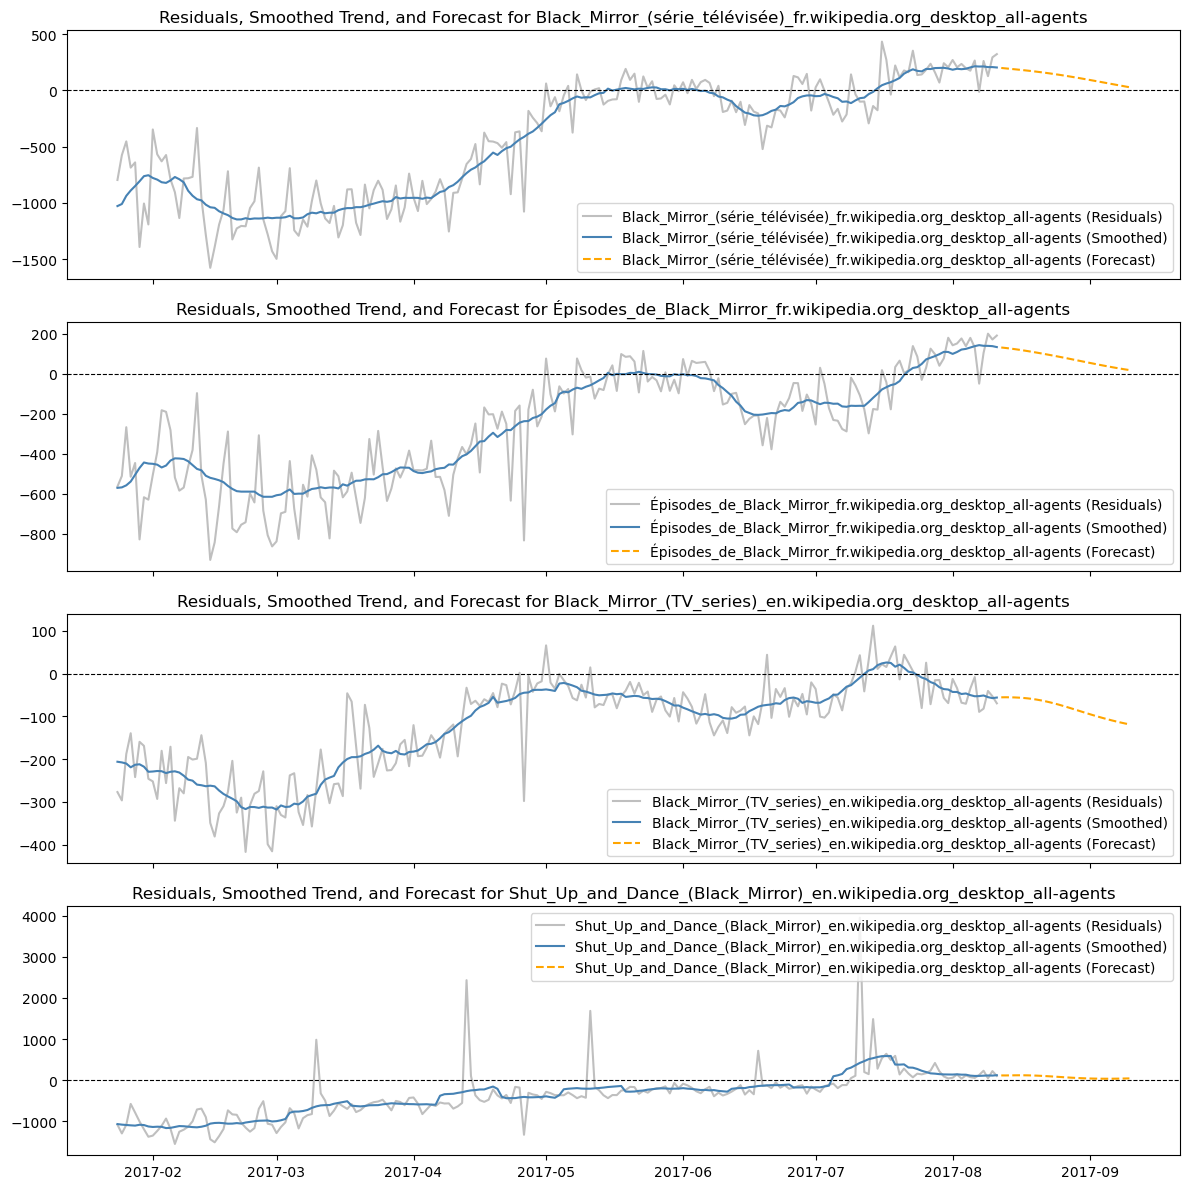

In [40]:
forecasted_residuals_df = forecast_residuals_with_VAR(residual_df, cluster_page_names=cluster_page_names, plot=True)

## Model Evaluation

To assess the performance of our forecasting models on the unseen test data, we define three evaluation metrics that capture different aspects of model quality:

### 1. **Mean Absolute Error (MAE)**  
MAE provides an interpretable, scale-sensitive measure of average forecasting error:
$$
\text{MAE} = \frac{1}{n} \sum_{t=1}^{n} |y_t - \hat{y}_t|
$$
This metric gives a clear sense of the typical magnitude of error, expressed in the same units as the data (i.e. page views). This can be used for evaluating individual pages, however is not a good measure when averaged across pages, since it is skewed by large page counts.

### 2. **Symmetric Mean Absolute Percentage Error (SMAPE)**  
SMAPE accounts for relative error, making it useful when comparing performance across time series with very different scales:
$$
\text{SMAPE} = \frac{100\%}{n} \sum_{t=1}^{n} \frac{2 |y_t - \hat{y}_t|}{|y_t| + |\hat{y}_t| + \epsilon}
$$
Here, $\epsilon$ is a small constant added to avoid division by zero. SMAPE is bounded between 0 and 200% (lower is better), making it more robust for datasets with a wide range of values.

### 3. **Within Confidence Interval (Within CI)**  
This metric evaluates the reliability of the model's uncertainty estimates. It measures the percentage of true observations that fall within the model’s predicted confidence interval (99% in our case):
$$
\text{Within CI (\%)} = \frac{1}{n} \sum_{t=1}^{n} \mathbb{1}\left[y_t \in [\hat{y}_t^{\text{lower}}, \hat{y}_t^{\text{upper}}]\right] \times 100
$$
A well-calibrated model should contain the true values within its CI the expected proportion of the time (e.g. ~99% for a 99% CI).


Together, these metrics balance accuracy, robustness across scales, and uncertainty calibration.


In [ ]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import poisson, nbinom

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def within_ci(y_true, lower, upper):
    return np.mean((y_true >= lower) & (y_true <= upper)) * 100

def evaluate_forecasts(
    train_df,
    test_df,
    simple_model_forecast_df,
    forecasted_residuals_df,
    cluster_page_names,
    plot=False,
    alpha=0.005,
    history_days=30
):
    """
    Evaluate simple and corrected forecasts using MAE, SMAPE, and CI coverage.

    Parameters:
    -----------
    clean_train_df : pd.DataFrame
    clean_test_df : pd.DataFrame
    simple_model_forecast_df : pd.DataFrame
    forecasted_residuals_df : pd.DataFrame
    cluster_page_names : list of str
    plot : bool (default=False)
        Whether to generate visual plots.
    alpha : float (default=0.005)
        Confidence level for uncertainty intervals.
    history_days : int (default=180)
        Number of days before forecast start to show as historical data in plots.

    Returns:
    --------
    pd.DataFrame with evaluation metrics for each page.
    """


    # Forecast window
    forecast_start = forecasted_residuals_df.index[0]
    history_start = forecast_start - pd.Timedelta(days=history_days)

    # Extract series
    history = train_df.loc[cluster_page_names].T.loc[history_start:forecast_start - pd.Timedelta(days=1)]
    actual = test_df.loc[cluster_page_names].T.loc[forecasted_residuals_df.index]
    simple_forecast = simple_model_forecast_df.loc[cluster_page_names].T.loc[forecasted_residuals_df.index]
    corrected_forecast = (simple_forecast + forecasted_residuals_df[cluster_page_names]).clip(lower=0)

    results = []

    if plot:
        fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    for i, page in enumerate(cluster_page_names):
        y_true = actual[page]
        y_simple = simple_forecast[page]
        y_corrected = corrected_forecast[page]

        # Metrics
        try:
            mae_simple = mean_absolute_error(y_true, y_simple)
            smape_simple = smape(y_true, y_simple)
            mae_corrected = mean_absolute_error(y_true, y_corrected)
            smape_corrected = smape(y_true, y_corrected)
        except ValueError:
            mae_simple = np.nan
            smape_simple = np.nan
            mae_corrected = np.nan
            smape_corrected = np.nan

        # Poisson CI (simple)
        lower_poisson = np.clip(poisson.ppf(0.001, y_simple), a_min=0, a_max=None)
        upper_poisson = poisson.ppf(0.99, y_simple)
        within_poisson = within_ci(y_true, lower_poisson, upper_poisson)

        # NegBin CI (corrected)
        lower_nb, upper_nb = neg_binomial_interval(y_corrected, alpha=alpha)
        within_nb = within_ci(y_true, lower_nb, upper_nb)

        # Store results
        results.append((page, mae_corrected, mae_simple, smape_corrected, smape_simple, within_nb, within_poisson))

        # Plot
        if plot and i <4:
            ax = axes[i] if len(cluster_page_names) > 1 else axes
            ax.plot(history.index, history[page], color="gray", label="History (Train)")
            ax.plot(y_simple.index, y_simple, color="steelblue", alpha=0.7,
                    label=f"Simple Forecast\nMAE={mae_simple:.1f}, SMAPE={smape_simple:.1f}%, In CI={within_poisson:.1f}%")
            ax.fill_between(y_simple.index, lower_poisson, upper_poisson, color="steelblue", alpha=0.2)

            ax.plot(y_corrected.index, y_corrected, color="orange",
                    label=f"Corrected Forecast\nMAE={mae_corrected:.1f}, SMAPE={smape_corrected:.1f}%, In CI={within_nb:.1f}%")
            ax.fill_between(y_corrected.index, lower_nb, upper_nb, color="orange", alpha=0.2)

            ax.scatter(y_true.index, y_true, color="red", label="Actual (Test)", marker="x")
            ax.axvline(forecast_start, color="black", linestyle="--", label="Forecast Start" if i == 0 else None)
            ax.set_title(page)
            ax.legend(loc='upper left')
            

    if plot:
        plt.tight_layout()
        plt.show()

    return results


Let's look at the performance on a few examples

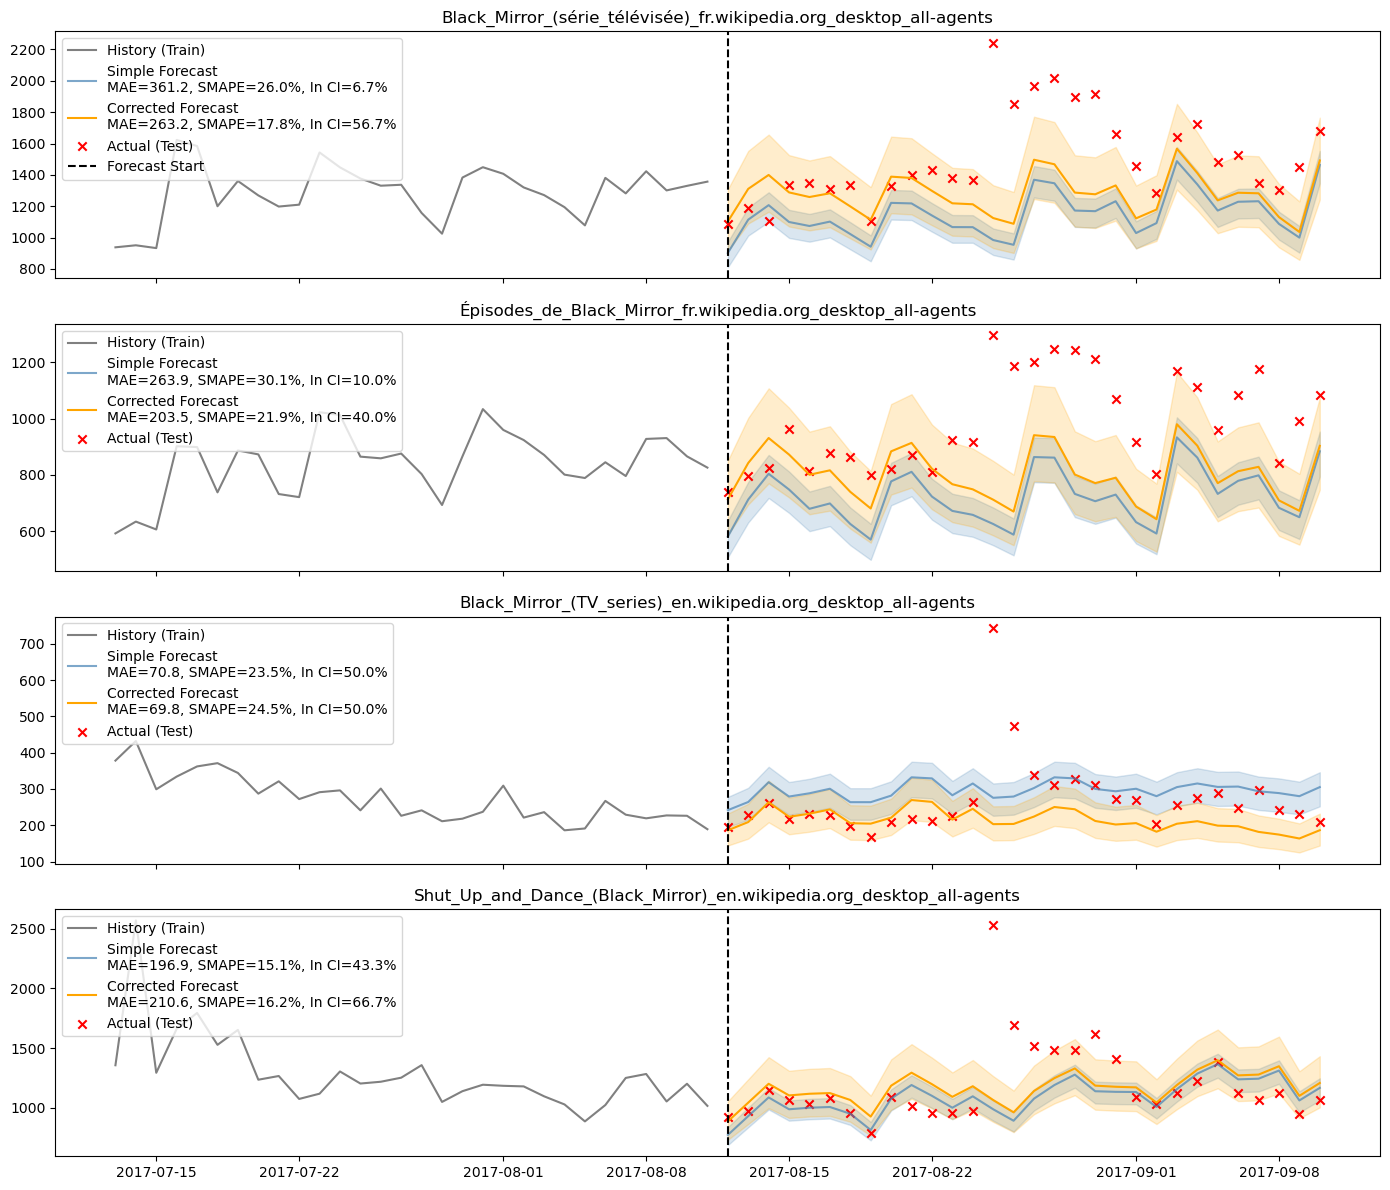

In [42]:
_ = evaluate_forecasts(
    train_df,
    test_df,
    simple_model_forecast_df,
    forecasted_residuals_df,
    cluster_page_names,
    plot=True  # optional
)

Cluster ID: 3414


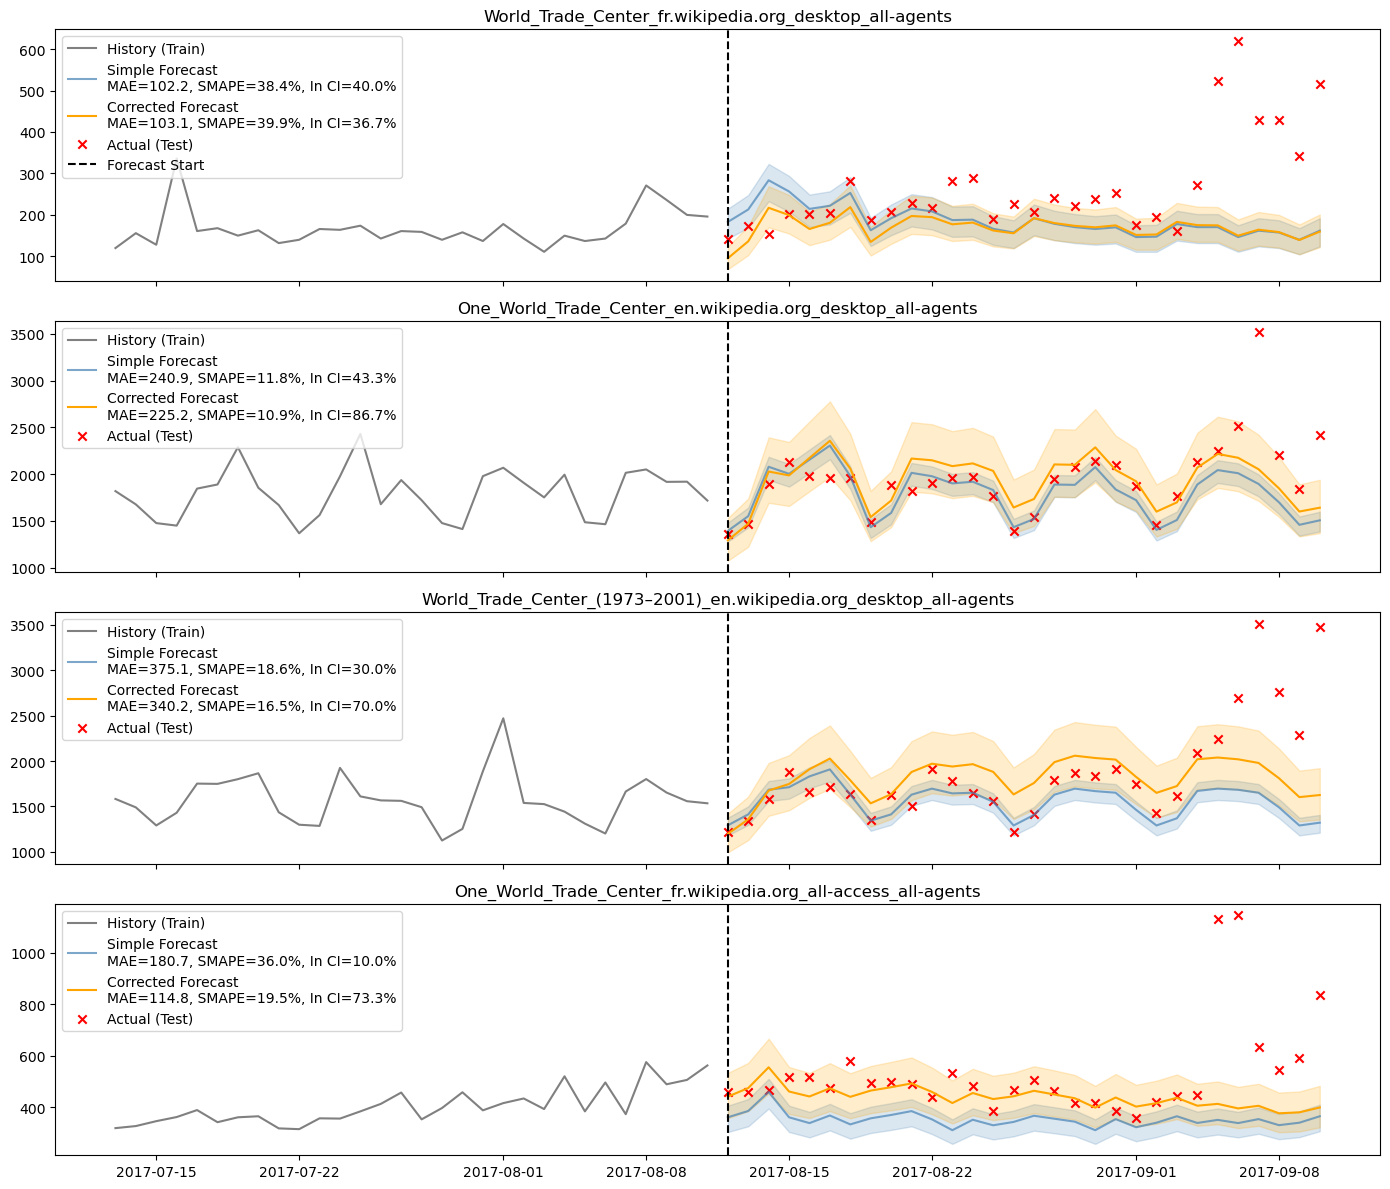

In [43]:
WTC_cluster_page_names = train_df.index[
    train_df.index.str.contains("World_Trade_Center", case=False)
    ]
# Get the cluster ID for the first match
cluster_id = train_df.loc[WTC_cluster_page_names, "cluster"].unique()[0]
print("Cluster ID:", cluster_id)

WTC_forecasted_residuals_df = forecast_residuals_with_VAR(residual_df, cluster_page_names=WTC_cluster_page_names, plot=False)

_ = evaluate_forecasts(
    train_df,
    test_df,
    simple_model_forecast_df,
    WTC_forecasted_residuals_df,
    WTC_cluster_page_names,
    plot=True  # optional
)

Cluster ID: 722_0


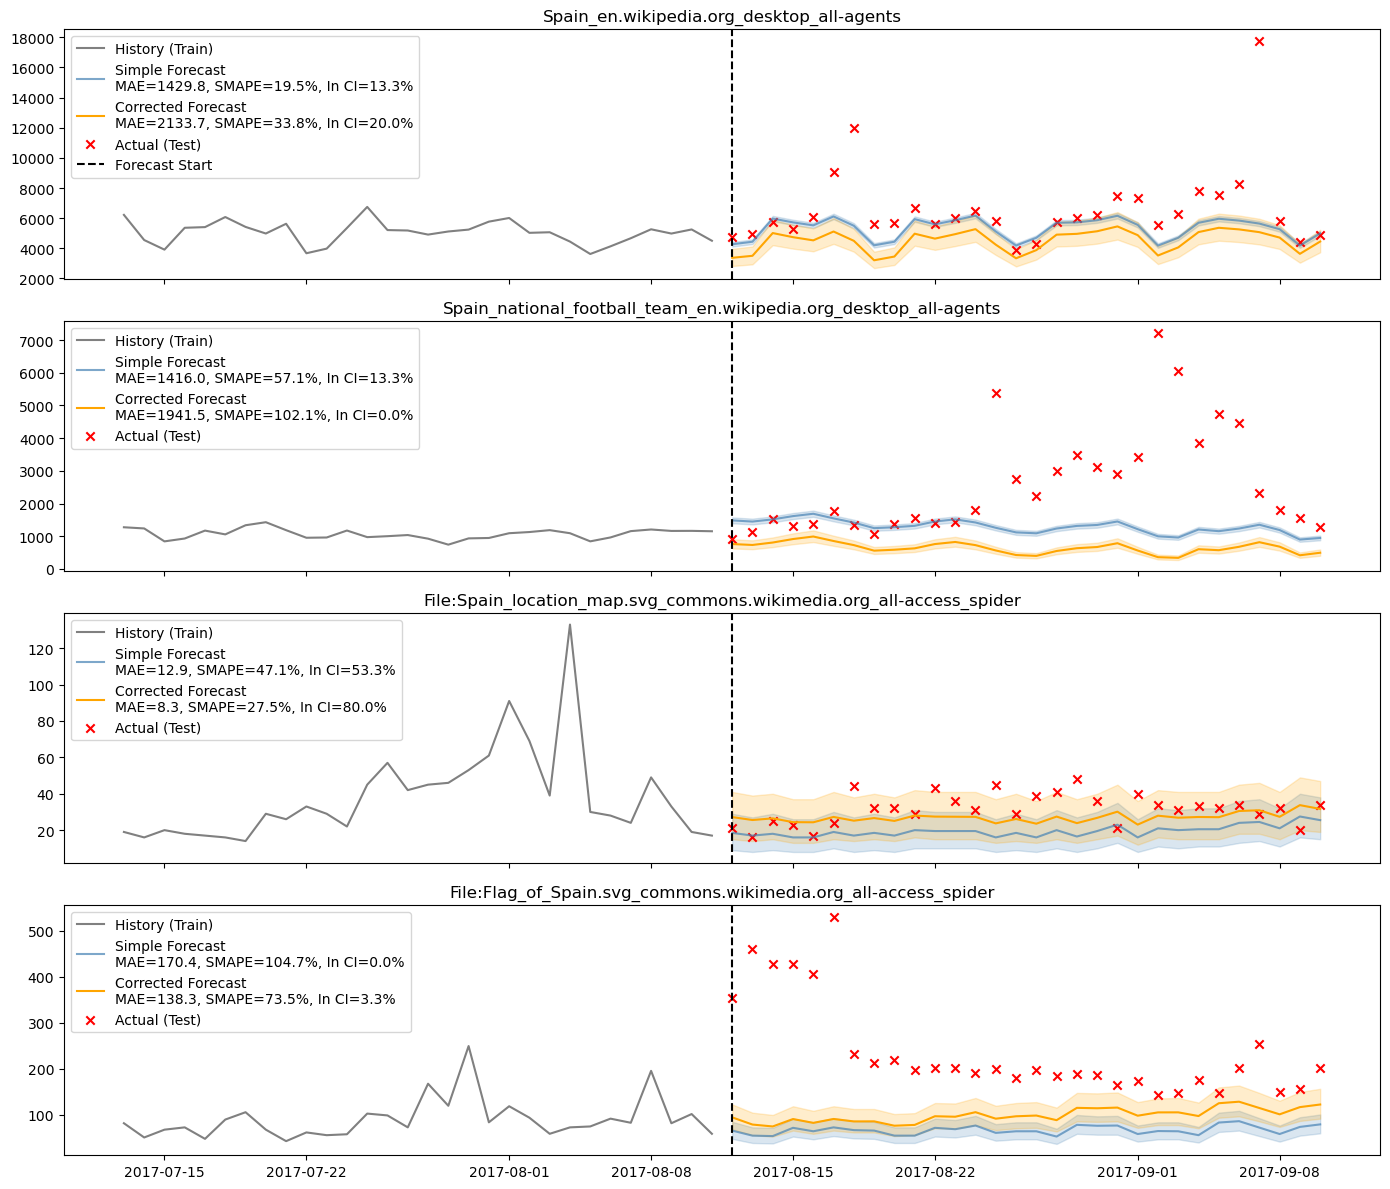

In [ ]:
spain_cluster_page_names = train_df.index[
    train_df.index.str.contains("Spain", case=False)
    ]
# Get the cluster ID for the first match
cluster_id = train_df.loc[spain_cluster_page_names, "cluster"].unique()[0]
print("Cluster ID:", cluster_id)

spain_forecasted_residuals_df = forecast_residuals_with_VAR(residual_df, cluster_page_names=spain_cluster_page_names, plot=False)

_ = evaluate_forecasts(
    train_df,
    test_df,
    simple_model_forecast_df,
    spain_forecasted_residuals_df,
    spain_cluster_page_names,
    plot=True  # optional
)

### Evaluating the Improved Model

The improved model demonstrates **modest gains in performance** on the validation examples — though there remains considerable scope for improvement.

#### Key Observations:

1. **Improved Trend Representation**  
   The model shows a slightly improved ability to capture **underlying trends**, correcting for some of the bias observed in the simple model. Further improvements could be achieved by more thorough tuning of the VAR model or using a **VARIMA** formulation — both of which would benefit from additional time and computational resources.

2. **Persistently Underestimated Uncertainty**  
   Even after adopting a **Negative Binomial** distribution to model forecast uncertainty, the model still tends to **underestimate variability**, particularly for high-volume pages or those with large fluctuations. A more principled solution would involve **jointly learning the uncertainty** during the learning process (e.g  maximum-likelihood/Bayesian estimation of a probabilistic model).

3. **Inability to Anticipate External Shocks**  
   The model continues to struggle with **sudden spikes in activity** (e.g., media releases or news events), which are not predictable from past residual patterns alone. These could be better addressed by introducing **external event features**, or leveraging **attention mechanisms** in a sequential deep learning model.


Let's now run the improved model across the full dataset.


In [45]:
# make empty df to store metrics
metrics_df = pd.DataFrame(columns=['page', 'MAE Improved', 'MAE Simple', 'SMAPE Improved', 'SMAPE Simple', '% Within CI Improved', '% Within CI Simple'])

# Loop over clusters
for cluster_id in train_df['cluster'].unique():
    cluster_page_names = train_df[train_df['cluster'] == cluster_id].index

    # Generate forecasted residuals
    forecasted_residuals_df = forecast_residuals_with_VAR(residual_df, cluster_page_names=cluster_page_names, plot=False)

    # Evaluate forecasts
    cluster_metrics = evaluate_forecasts(
        train_df,
        test_df,
        simple_model_forecast_df,
        forecasted_residuals_df,
        cluster_page_names,
        plot=False
    )
    # Ensure the result is a DataFrame with the expected columns
    if cluster_metrics:
        metrics_df = pd.concat([metrics_df, pd.DataFrame(cluster_metrics, columns=metrics_df.columns)], ignore_index=True)


# Make a table of the mean of each metric
summary_table = metrics_df.mean(numeric_only=True).to_frame(name='Mean').T
print("Summary of Forecast Evaluation Metrics (Means):")
display(summary_table)


Summary of Forecast Evaluation Metrics (Means):


MAE Improved  MAE Simple  SMAPE Improved  SMAPE Simple  \
Mean     380.08243  487.462078       41.100242     58.253281   

      % Within CI Improved  % Within CI Simple  
Mean             49.616173           46.642632